In [1]:
import deimos
import numpy as np
import pandas as pd
import time
import matplotlib.pyplot as plt
import os
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, KFold
import random as rd
import matplotlib
matplotlib.rcParams['figure.dpi'] = 100
import sys
import PeakDetective
import PeakDetective.detection_helper as detection_helper
import scipy.stats as stats
import seaborn as sb
from matplotlib.colors import LinearSegmentedColormap
from sklearn.metrics import confusion_matrix
import sklearn.metrics as met
import random as rd
import importlib
import pickle as pkl
import NeatMS as ntms

def makePRCPlot(pred,true,noSkill=True,label=""):

    prec, recall, threshs = met.precision_recall_curve(true, pred)

    auc = np.round(met.auc(recall, prec), 4)

    plt.plot(recall, prec, label=label + " prAUC=" + str(auc))
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    if noSkill:
        numPositive = len([x for x in true if x > 0.5])
        numNegative = len(true) - numPositive
        plt.plot([0, 1.0],
                 [numPositive / float(numPositive + numNegative), numPositive / float(numPositive + numNegative)],
                 label="NSL prAUC=" + str(
                     np.round(numPositive / float(numPositive + numNegative), 4)))
    plt.legend()
    return auc

def makeViolinPlot(pred,true):
    
    plt_dict = {}
    
    for p,t in zip(pred,true):
        if t > 0.5:
            group = "true peak"
        else:
            group = "artifact"
        plt_dict[len(plt_dict)] = {"group":group,"prediction":p}
        
    plt_dict = pd.DataFrame.from_dict(plt_dict,orient="index")
    
    sb.violinplot(data=plt_dict,x="group",y="prediction",cut=0)
    
def makeROCPlot(pred,true,label="",noSkill=True):

    fpr, tpr, threshs = met.roc_curve(true, pred)

    auc = np.round(met.auc(fpr, tpr), 4)

    plt.plot(fpr, tpr, label=label + ": AUROC=" + str(auc))
    plt.xlabel("FPR")
    plt.ylabel("TPR")
    if noSkill:
        plt.plot([0, 1.0],[0,1.0],label="NSL")
    plt.legend()
    return auc

def plot_overlayedEIC(rawdatas,mz,rt_start,rt_end,resolution=60,smoothing=0,alpha=0.3,color="black"):
    ts = np.linspace(rt_start,rt_end,resolution)
    for data in rawdatas:
        s = data.interpolate_data(mz,rt_start,rt_end)
        ints  = [np.max([x,0]) for x in s(ts)]
        plt.plot(ts,ints,alpha=alpha)

In [2]:
#importlib.reload(PeakDetective)

In [3]:
resolution = 60
window = 1.0
align = True

In [4]:
#covid_plasma
datadir = "D:/PeakDetective/data/covid_plasma/"
ms1ppm = 25.5
peakWidth = (13.8,114.6)
s2n = 13.6
noise = 1
mzDiff = 0.0144
prefilter = 5
cutoff = 0.9 #default cutoff from last run

In [57]:
#ST000081
datadir = "D:/PeakDetective/data/ST000081/"
ms1ppm = 11.5
peakWidth = (8.5,31.3)
s2n = 6.81
noise = 1
mzDiff = 0.0144
prefilter = 5.4
cutoff = 0.6 #default cutoff from last run

In [110]:
#ST001882_GT_RP_Positive
datadir = "D:/PeakDetective/data/ST001882_GT_RP_Positive/"
ms1ppm = 11.5
peakWidth = (8.576,30)
s2n = 9.1
noise = 12970
mzDiff = 0.0144
prefilter = 1
cutoff = 0.5 #default cutoff from last run

In [5]:
rawDataDir = datadir + "tmp/"

In [6]:
det = detection_helper.PeakList()
det.runXCMS(datadir, "xcms_peak_lis2t.csv", "negative", ms1ppm, peakWidth,s2n=s2n,noise=noise,mzDiff=mzDiff,prefilter=prefilter)
det.readXCMSPeakList(datadir+"xcms_peak_list.csv")
#det.to_skyline(datadir+"xcms_peak_list_transition_list.csv","Negative",moleculeListName = "XCMS peaks")
peakList = pd.DataFrame(det.peakList)
#peakList = peakList[["mz","rt"]]
peakList

FileNotFoundError: [Errno 2] No such file or directory: 'D:/PeakDetective/data/covid_plasma/xcms_peak_lis2t.csv'

In [7]:
neatMSPeakList = pd.read_csv(datadir + "xcms_peak_list.csv",sep="\t",index_col=0)
neatMSPeakList["feature_id"] = neatMSPeakList.index.values
neatMSPeakList["feature_id2"] = neatMSPeakList.index.values
neatMSPeakList = neatMSPeakList.melt(id_vars = ["mzmed","rtmed","rtmin","rtmax","feature_id"],
                    value_vars = [x for x in neatMSPeakList.columns.values if ".mzML" in x],
                   var_name="sample", value_name="into")
neatMSPeakList["mzmin"] = neatMSPeakList["mzmed"].values - (ms1ppm * neatMSPeakList["mzmed"].values) / 1e6
neatMSPeakList["mzmax"] = neatMSPeakList["mzmed"].values + (ms1ppm * neatMSPeakList["mzmed"].values) / 1e6
neatMSPeakList["intb"] = neatMSPeakList["into"].values
neatMSPeakList["maxo"] = neatMSPeakList["into"].values
neatMSPeakList["sn"] = [10 for _ in range(len(neatMSPeakList))]
neatMSPeakList["sample_name"] = neatMSPeakList["sample"].values
neatMSPeakList["rtmin"] = neatMSPeakList["rtmin"].values - .2 * 60
neatMSPeakList["rtmax"] = neatMSPeakList["rtmin"].values + .2 * 60
neatMSPeakList = neatMSPeakList.rename({"mzmed":"mz","rtmed":"rt"},axis=1)

neatMSPeakList.to_csv(datadir + "neatms_peak_list.csv",index=False)
neatMSPeakList


mz          rt       rtmin       rtmax feature_id  \
0        150.112310   44.847397   32.847004   44.847004    FT00001   
1        150.026482  104.976143   92.861908  104.861908    FT00002   
2        150.026490  170.748657  158.745468  170.745468    FT00003   
3        150.062904   75.329934   63.305313   75.305313    FT00004   
4        150.091273   50.744864   37.897064   49.897064    FT00005   
...             ...         ...         ...         ...        ...   
225262  1974.536430  528.918945  516.918945  528.918945    FT32177   
225263  1979.207415  374.987793  362.395142  374.395142    FT32178   
225264  1980.210251  374.978076  362.411835  374.411835    FT32179   
225265  1981.211674  374.972961  362.423401  374.423401    FT32180   
225266  1982.212953  374.974823  362.407043  374.407043    FT32181   

            sample          into        mzmin        mzmax          intb  \
0       QC_01.mzML  1.974936e+06   150.110584   150.114036  1.974936e+06   
1       QC_01.mzML  2.826669e+07   150.024757   150.028207  2.826669e+07   
2       QC_01.mzML  8.213799e+06   150.024765   150.028215  8.213799e+06   
3       QC_01.mzML  3.205281e+05   150.061178   150.064630  3.205281e+05   
4       QC_01.mzML  2.072345e+05   150.089547   150.092999  2.072345e+05   
...            ...           ...          ...          ...           ...   
225262  QC_07.mzML  2.039624e+05  1974.513723  1974.559137  2.039624e+05   
225263  QC_07.mzML  7.916662e+04  1979.184654  1979.230176  7.916662e+04   
225264  QC_07.mzML  2.108537e+05  1980.187479  1980.233024  2.108537e+05   
225265  QC_07.mzML  2.104139e+05  1981.188890  1981.234458  2.104139e+05   
225266  QC_07.mzML  1.249721e+05  1982.190158  1982.235748  1.249721e+05   

                maxo  sn sample_name  
0       1.974936e+06  10  QC_01.mzML  
1       2.826669e+07  10  QC_01.mzML  
2       8.213799e+06  10  QC_01.mzML  
3       3.205281e+05  10  QC_01.mzML  
4       2.072345e+05  10  QC_01.mzML  
...              ...  ..         ...  
225262  2.039624e+05  10  QC_07.mzML  
225263  7.916662e+04  10  QC_07.mzML  
225264  2.108537e+05  10  QC_07.mzML  
225265  2.104139e+05  10  QC_07.mzML  
225266  1.249721e+05  10  QC_07.mzML  

[225267 rows x 13 columns]

In [8]:
feature_table_path = datadir+"neatms_peak_list.csv"
input_data = 'xcms'
experiment = ntms.Experiment(rawDataDir, feature_table_path, input_data)

KeyboardInterrupt: 

In [ ]:
nn_handler = ntms.NN_handler(experiment,min_scan_num=0)

In [ ]:
model_path = "../data/neatms/neatms_default_model.h5"
nn_handler.create_model(model = model_path)

In [ ]:
# Set the threshold to 0.22
threshold=0.22
# Run the prediction
nn_handler.predict_peaks(threshold)

In [124]:
# We create the dataframe using this function
NeatMS_output_df = experiment.export_to_dataframe()
# And display it
NeatMS_output_df

feature ID sample          m/z  retention time        height  \
0             1834  QC_01   150.112310        0.747457  1.974936e+06   
1             1834  QC_02   150.112310        0.747457  1.858493e+06   
2             1834  QC_03   150.112310        0.747457  1.798871e+06   
3             1834  QC_04   150.112310        0.747457  1.757297e+06   
4             1834  QC_05   150.112310        0.747457  1.773365e+06   
...            ...    ...          ...             ...           ...   
222235       34014  QC_03  1982.212953        6.249580  1.171374e+05   
222236       34014  QC_04  1982.212953        6.249580  1.096281e+05   
222237       34014  QC_05  1982.212953        6.249580  7.411829e+04   
222238       34014  QC_06  1982.212953        6.249580  1.437213e+05   
222239       34014  QC_07  1982.212953        6.249580  1.249721e+05   

                area         label  
0       1.974936e+06  High_quality  
1       1.858493e+06         Noise  
2       1.798871e+06  High_quality  
3       1.757297e+06  High_quality  
4       1.773365e+06  High_quality  
...              ...           ...  
222235  1.171374e+05  High_quality  
222236  1.096281e+05  High_quality  
222237  7.411829e+04  High_quality  
222238  1.437213e+05  High_quality  
222239  1.249721e+05  High_quality  

[222240 rows x 7 columns]

In [125]:
NeatMS_output_df.to_csv(datadir + "NeatMS_output_df.csv")

In [113]:
NeatMS_output_df= pd.read_csv(datadir + "NeatMS_output_df.csv",index_col=0)
NeatMS_output_df

feature ID sample          m/z  retention time        height  \
0             1834  QC_01   150.112310        0.747457  1.974936e+06   
1             1834  QC_02   150.112310        0.747457  1.858493e+06   
2             1834  QC_03   150.112310        0.747457  1.798871e+06   
3             1834  QC_04   150.112310        0.747457  1.757297e+06   
4             1834  QC_05   150.112310        0.747457  1.773365e+06   
...            ...    ...          ...             ...           ...   
222235       34014  QC_03  1982.212953        6.249580  1.171374e+05   
222236       34014  QC_04  1982.212953        6.249580  1.096281e+05   
222237       34014  QC_05  1982.212953        6.249580  7.411829e+04   
222238       34014  QC_06  1982.212953        6.249580  1.437213e+05   
222239       34014  QC_07  1982.212953        6.249580  1.249721e+05   

                area         label  
0       1.974936e+06  High_quality  
1       1.858493e+06         Noise  
2       1.798871e+06  High_quality  
3       1.757297e+06  High_quality  
4       1.773365e+06  High_quality  
...              ...           ...  
222235  1.171374e+05  High_quality  
222236  1.096281e+05  High_quality  
222237  7.411829e+04  High_quality  
222238  1.437213e+05  High_quality  
222239  1.249721e+05  High_quality  

[222240 rows x 7 columns]

In [7]:
files = [x for x in os.listdir(datadir) if ".mzML" in x]
print(files)
raw_data = []
for file in files:
    temp = PeakDetective.rawData()
    temp.readRawDataFile(datadir + file,ms1ppm)
    raw_data.append(temp)
    

['B1_NIST1950_1_6540.mzML', 'B1_NIST1950_2_6540.mzML', 'B1_NIST1950_3_6540.mzML']


In [8]:
integ = PeakDetective.PeakDetective(numCores = 15,resolution=resolution)

In [ ]:
if __name__ == "__main__":
    inds = list(peakList.index.values)
    inds = rd.sample(inds,500)
    tmp = peakList.loc[inds,:]
    print(tmp)
    peakList_labeled = integ.label_peaks(raw_data[0],tmp)
    peakList_labeled.to_csv(datadir + files[0].replace(".mzML","_classified_peaks.csv"))

                mz         rt   rt_start     rt_end  B1_NIST1950_1_6540.mzML  \
FT0215  106.040814   6.669976   6.669976   6.669976             2.518828e+02   
FT0442  139.059390   1.345603   1.345603   1.345603             3.995170e+03   
FT0450  140.990744   5.622617   5.622617   5.622617             1.755105e+03   
FT1174  221.154240   0.942909   0.934601   0.951217             3.893987e+04   
FT4086  981.994883   7.634148   7.634148   7.634148             1.509238e+06   
...            ...        ...        ...        ...                      ...   
FT2510  366.125450   4.126029   4.092905   4.126433             3.173720e+03   
FT0837  187.042175   2.181400   2.164783   2.196974             2.619660e+05   
FT2248  329.921759   5.040746   5.040726   5.040767             2.850672e+03   
FT0646  165.019673   3.511350   3.494511   3.526639             7.771774e+04   
FT0674  168.972708  13.086900  13.070283  13.103534             1.905946e+05   

        B1_NIST1950_2_6540.mzML  B1_NIS

In [116]:
peakList_labeled = pd.read_csv(datadir + files[0].replace(".mzML","_classified_peaks.csv"),index_col=0)

In [9]:
if __name__ == "__main__":
    rts = peakList["rt"].values
    X_unaligned = integ.makeDataMatrix(raw_data,peakList["mz"],rts,align=False)

forming matrix |██████████████████████████████████████████████████| 100.0% 


In [10]:
if __name__ == "__main__":
    rts = peakList["rt"].values
    X = integ.makeDataMatrix(raw_data,peakList["mz"],rts,align=align)
    

forming matrix |██████████████████████████████████████████████████| 100.0% 
aligning EICs |██████████████████████████████████████████████████| 100.0% 


Text(0, 0.5, 'intensity')

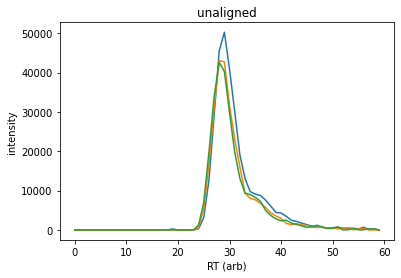

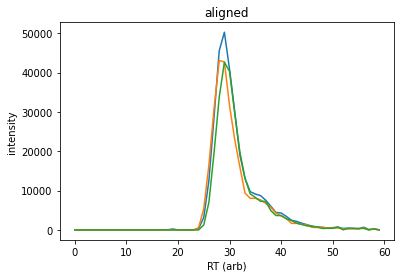

In [48]:
ind = rd.choice(list(range(len(peakList.index.values))))
aligned = []
unaligned = []
for x in range(len(raw_data)):
    aligned.append(X[x*len(peakList) + ind])
    unaligned.append(X_unaligned[x*len(peakList) + ind])
plt.figure()
plt.title("unaligned")
for x in unaligned:
    plt.plot(range(len(x)),x)
plt.xlabel("RT (arb)")
plt.ylabel("intensity")

plt.figure()
plt.title("aligned")
for x in aligned:
    plt.plot(range(len(x)),x)
plt.xlabel("RT (arb)")
plt.ylabel("intensity")
    

In [156]:
if __name__ == "__main__":
    rts = peakList_labeled["rt"].values
    X_labeled = integ.makeDataMatrix(raw_data[:1],peakList_labeled["mz"],peakList_labeled["rt"],align=False)
    y_labeled = peakList_labeled["classification"].values
    y_labeled = np.array([[-1*y + 1,y] for y in y_labeled])

forming matrix |██████████████████████████████████████████████████| 100.0% 


In [19]:
raw_data[0].rts[:10]

[]

In [ ]:
if __name__ == "__main__":
    oldCores = integ.numCores
    integ.numCores = 1
    X_signal = integ.generateSignalPeaks(peakList,raw_data[:1],n=100)
    X_noise = integ.generateFalsePeaks(peakList,raw_data[:1],n=100)
    X_syn = np.concatenate((X_signal,X_noise),axis=0)
    y_syn = np.array([[0.0,1.0] for _ in X_signal] + [[1.0,0.0] for _ in X_noise])
    integ.numCores = oldCores

In [15]:
pkl.dump([X,X_labeled,y_labeled,X_syn,y_syn],open(datadir + "model_selection_data.pkl","wb"))

In [117]:
[X,X_labeled,y_labeled,X_syn,y_syn] = pkl.load(open(datadir + "model_selection_data.pkl","rb"))

In [24]:
if __name__ == "__main__":
    integ.trainSmoother(peakList,raw_data,100000,10,64,0.1)

generating EICs...
forming matrix |██████████████████████████████████████████████████| 100.0% 
done
fitting smoother...
Epoch 1/10
1407/1407 [==============================] - 25s 17ms/step - loss: 0.1337 - mean_absolute_error: 0.0580 - val_loss: 0.0826 - val_mean_absolute_error: 0.0158
Epoch 2/10
1407/1407 [==============================] - 23s 17ms/step - loss: 0.0770 - mean_absolute_error: 0.0132 - val_loss: 0.0732 - val_mean_absolute_error: 0.0102
Epoch 3/10
1407/1407 [==============================] - 29s 21ms/step - loss: 0.0721 - mean_absolute_error: 0.0096 - val_loss: 0.0716 - val_mean_absolute_error: 0.0088
Epoch 4/10
1407/1407 [==============================] - 23s 16ms/step - loss: 0.0709 - mean_absolute_error: 0.0087 - val_loss: 0.0707 - val_mean_absolute_error: 0.0081
Epoch 5/10
1407/1407 [==============================] - 23s 16ms/step - loss: 0.0702 - mean_absolute_error: 0.0081 - val_loss: 0.0701 - val_mean_absolute_error: 0.0076
Epoch 6/10
1407/1407 [==================

In [25]:
integ.save(datadir + "smoothed_only/")

In [118]:
integ.load(datadir + "smoothed_only/")

In [119]:
valInds = list(range(len(X_labeled)))
valInds = rd.sample(valInds,k=250)
testInds = rd.sample(valInds,k=200)
valInds = [x for x in valInds if x not in testInds]

X_val = X_labeled[valInds]
y_val = y_labeled[valInds]

X_test = X_labeled[testInds]
y_test = y_labeled[testInds]

X_labeled = X_labeled[[x for x in range(len(X_labeled)) if x not in valInds + testInds]]
y_labeled = y_labeled[[x for x in range(len(y_labeled)) if x not in valInds + testInds]]

In [120]:
peaks_test = peakList_labeled.iloc[testInds,:].reset_index()
peaks_test

index           mz        rt  rt_start    rt_end    QC_01.mzML  \
0    FT14895   743.581501  5.674766  5.665159  5.683969  1.829169e+05   
1    FT11371   651.480727  3.706680  3.706645  3.706768  2.484877e+07   
2    FT02866   339.231731  3.810430  3.810430  3.810430  5.507272e+04   
3    FT03055   348.202281  2.306607  2.297154  2.354094  5.162621e+05   
4    FT04573   415.236194  2.514900  2.514827  2.515119  9.670136e+05   
..       ...          ...       ...       ...       ...           ...   
195  FT29130  1276.852663  9.500146  9.500146  9.500146  5.411608e+04   
196  FT16862   795.555603  3.547284  3.537970  3.547312  6.293791e+07   
197  FT09057   587.701837  0.738146  0.738141  0.747480  4.094488e+05   
198  FT00089   159.116535  2.911193  2.901890  2.986116  1.032033e+07   
199  FT18184   825.655308  4.633701  4.633701  4.633701  7.234169e+04   

       QC_02.mzML    QC_03.mzML    QC_04.mzML    QC_05.mzML    QC_06.mzML  \
0    1.766859e+05  1.256365e+05  1.443442e+05  1.936227e+05  1.601780e+05   
1    2.460210e+07  2.341706e+07  2.361001e+07  2.452555e+07  2.506144e+07   
2    7.763729e+04  8.904753e+04  4.871055e+04  1.061938e+05  5.753097e+04   
3    5.355512e+05  6.188076e+05  4.816884e+05  5.908164e+05  5.843892e+05   
4    9.220717e+05  9.652715e+05  9.481381e+05  1.025294e+06  9.621343e+05   
..            ...           ...           ...           ...           ...   
195  8.811965e+04  8.974891e+04  1.020925e+05  7.181541e+04  9.319944e+04   
196  6.150057e+07  6.495250e+07  6.586306e+07  6.822698e+07  6.500870e+07   
197  3.590366e+05  3.613025e+05  3.187421e+05  1.020120e+05  1.460561e+05   
198  2.186564e+05  1.027575e+07  5.514844e+05  8.329849e+06  1.092835e+07   
199  8.978570e+04  8.162570e+04  1.041014e+05  1.178617e+05  9.887497e+04   

       QC_07.mzML  classification  
0    1.606843e+05             0.0  
1    2.558655e+07             1.0  
2    1.107432e+05             1.0  
3    5.694778e+05             1.0  
4    1.063705e+06             1.0  
..            ...             ...  
195  9.035210e+04             1.0  
196  6.572849e+07             1.0  
197  1.811723e+05             1.0  
198  4.791558e+06             0.0  
199  9.532961e+04             0.0  

[200 rows x 13 columns]

In [121]:
pkl.dump([peaks_test,X_val,y_val,X_test,y_test,X_labeled,y_labeled],open(datadir+"eval_data.pkl","wb"))

In [122]:
[peaks_test,X_val,y_val,X_test,y_test,X_labeled,y_labeled] = pkl.load(open(datadir+"eval_data.pkl","rb"))

In [123]:
filt = NeatMS_output_df[NeatMS_output_df["sample"] == files[0].replace(".mzML","")]
filt

feature ID sample          m/z  retention time        height  \
0             1834  QC_01   150.112310        0.747457  1.974936e+06   
7             1835  QC_01   150.026482        1.749602  2.826669e+07   
14            1836  QC_01   150.026490        2.845811  8.213799e+06   
21            1837  QC_01   150.062904        1.255499  3.205281e+05   
28            1838  QC_01   150.091273        0.845748  2.072345e+05   
...            ...    ...          ...             ...           ...   
222205       34010  QC_01  1974.536430        8.815316  1.895676e+04   
222212       34011  QC_01  1979.207415        6.249797  7.459506e+04   
222219       34012  QC_01  1980.210251        6.249635  1.857563e+05   
222226       34013  QC_01  1981.211674        6.249549  1.741973e+05   
222233       34014  QC_01  1982.212953        6.249580  1.102636e+05   

                area         label  
0       1.974936e+06  High_quality  
7       2.826669e+07         Noise  
14      8.213799e+06         Noise  
21      3.205281e+05         Noise  
28      2.072345e+05         Noise  
...              ...           ...  
222205  1.895676e+04  High_quality  
222212  7.459506e+04  High_quality  
222219  1.857563e+05  High_quality  
222226  1.741973e+05  High_quality  
222233  1.102636e+05  High_quality  

[31769 rows x 7 columns]

In [124]:
matchIDs = {}
for index,row in peaks_test.iterrows():
    for index2,row2 in filt.iterrows():
        if row2["m/z"] > row["mz"] + 0.001:
            break
        if np.abs(row["rt"] - row2["retention time"]) < 0.03:
            if np.abs(row["mz"] - row2["m/z"]) < 0.001:
                matchIDs[index] = index2
                break
print(len(matchIDs))        

84


In [125]:
order = list(matchIDs.keys())
filt = filt.loc[[matchIDs[x] for x in order],:]
classification = []
for index,row in filt.iterrows():
    if row["label"] == "High_quality":
        classification.append(1.0)
    elif row["label"] == "Low_quality":
        classification.append(0.5)
    else:
        classification.append(0.0)
filt["classification"] = classification
filt

feature ID sample          m/z  retention time        height  \
20674         4888  QC_01   348.202281        2.306607  5.162621e+05   
31160         6406  QC_01   415.236194        2.514900  9.670136e+05   
38526         7473  QC_01   464.130636        2.099991  4.530466e+05   
193209       29836  QC_01  1162.821425        6.886276  3.420084e+05   
56036        10019  QC_01   561.028082        1.580255  3.518102e+05   
...            ...    ...          ...             ...           ...   
168266       26248  QC_01   976.867846        8.326226  1.275476e+06   
131175       20887  QC_01   846.201207        8.148647  1.288281e+05   
16536         4281  QC_01   317.226233        2.590780  2.576830e+05   
62019        10890  QC_01   587.701837        0.738146  4.094488e+05   
607           1922  QC_01   159.116535        2.911193  1.032033e+07   

                area         label  classification  
20674   5.162621e+05  High_quality             1.0  
31160   9.670136e+05         Noise             0.0  
38526   4.530466e+05  High_quality             1.0  
193209  3.420084e+05  High_quality             1.0  
56036   3.518102e+05  High_quality             1.0  
...              ...           ...             ...  
168266  1.275476e+06         Noise             0.0  
131175  1.288281e+05         Noise             0.0  
16536   2.576830e+05  High_quality             1.0  
62019   4.094488e+05  High_quality             1.0  
607     1.032033e+07         Noise             0.0  

[84 rows x 8 columns]

In [126]:
X_labeled_norm = PeakDetective.normalizeMatrix(X_labeled)
X_labeled_smoothed = integ.smoother.predict(PeakDetective.normalizeMatrix(X_labeled))

8/8 [==============================] - 0s 7ms/step


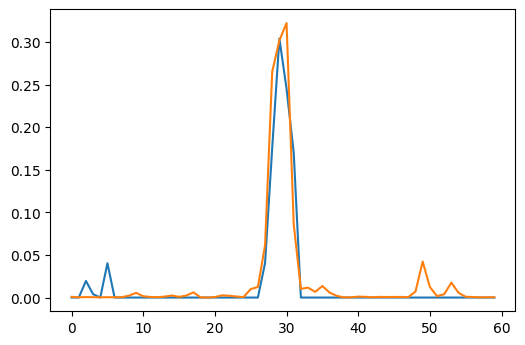

In [127]:
ind = rd.choice(list(range(len(X_labeled))))
plt.plot(X_labeled_norm[ind])
plt.plot(X_labeled_smoothed[ind])

In [128]:
X_test = X_test[order]
y_test = y_test[order]

In [129]:
y_test_scores_neat_ms = filt["classification"].values

In [130]:
if __name__ == "__main__":
    integ.trainClassifier(X_labeled,y_labeled,X_val,y_val,200,1000,4,1)

2/2 [==============================] - 0s 6ms/step
loss: 0.4825778007507324 mean_absolute_error: 0.2828364670276642 val loss: 0.500903308391571 val_mean_absolute_error: 0.2876870930194855 numEpochs: 625


In [131]:
integ.save(datadir + "supervised/")

In [132]:
integ.load(datadir + "supervised/")

In [133]:
y_test_scores_supervised = integ.classifyMatrix(X_test)

3/3 [==============================] - 0s 2ms/step


In [ ]:
# if __name__ == "__main__":
#      integ.trainClassifier(X_syn,y_syn,X_val,y_val,200,1000,32,5)

In [ ]:
# y_test_scores_syn = integ.classifyMatrix(X_test)

1/1 [==============================] - 0s 17ms/step
loss: 0.5034099817276001 mean_absolute_error: 0.30055099725723267 val loss: 0.4894525110721588 val_mean_absolute_error: 0.25605154037475586 numEpochs: 200
7036/7036 [==============================] - 8s 1ms/step


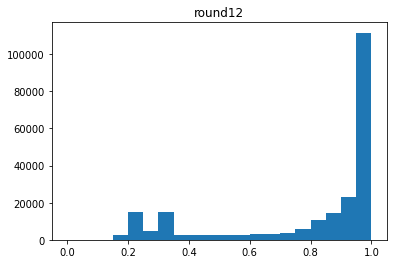

225137 unclassified features remaining
Continue with another iteration? (1=Yes, 0=No): 


 0


1/1 [==============================] - 0s 17ms/step


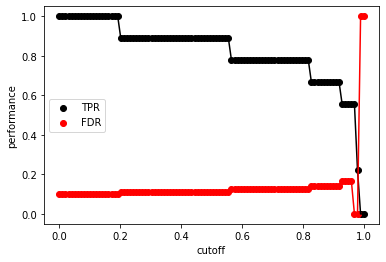

In [29]:
if __name__ == "__main__":
    integ.trainClassifierActive(X,[],[],200,1000,4,1,numVal = 10,numManualPerRound=10,inJupyter=True)

In [30]:
#cutoff = 0.5

In [31]:
integ.save(datadir + "active/")

In [134]:
integ.load(datadir + "active/")

In [135]:
y_test_scores_active_syn = integ.classifyMatrix(X_test)

3/3 [==============================] - 0s 2ms/step


In [136]:
if __name__ == "__main__":
    peak_curated,peak_scores,peak_intensities = integ.curatePeaks(raw_data,peakList,threshold=cutoff,align=align)
    peak_curated

generating EICs...
forming matrix |██████████████████████████████████████████████████| 100.0% 
aligning EICs |██████████████████████████████████████████████████| 100.0% 
7040/7040 [==============================] - 9s 1ms/step
integrating peaks...
integrating peaks |██████████████████████████████████████████████████| 100.0% 


In [137]:
predInt = []
file = files[0]
for index,row in peaks_test.loc[order,:].iterrows():
    predInt.append(peak_intensities.at[row["index"],datadir+file])


In [138]:
predCV = []
trueCV = []
for index,row in peaks_test.loc[order,:].iterrows():
    ints = [peak_intensities.at[row["index"],datadir+file] for file in files]
    cv = 1 - np.std(ints) / np.mean(ints)
    if not np.isnan(cv) and not np.isinf(cv) and cv > 0 and cv < 1:
        predCV.append(cv)
        trueCV.append(row["classification"])

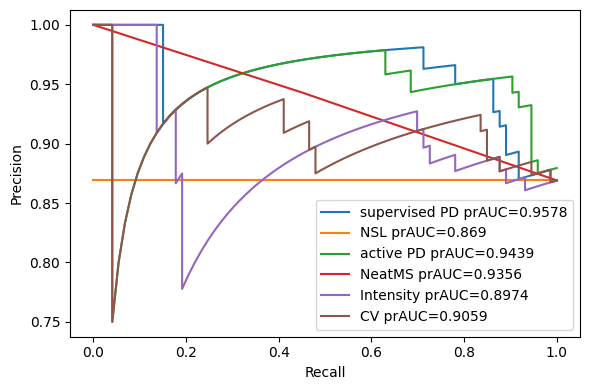

In [139]:
makePRCPlot(y_test_scores_supervised[:,1],y_test[:,1],noSkill=True,label="supervised PD")
makePRCPlot(y_test_scores_active_syn[:,1],y_test[:,1],noSkill=False,label="active PD")
makePRCPlot(y_test_scores_neat_ms,y_test[:,1],noSkill=False,label="NeatMS")
makePRCPlot(predInt,y_test[:,1],noSkill=False,label="Intensity")
makePRCPlot(predCV,trueCV,noSkill=False,label="CV")
plt.tight_layout()
plt.savefig(datadir+"PRC.png",dpi=300)

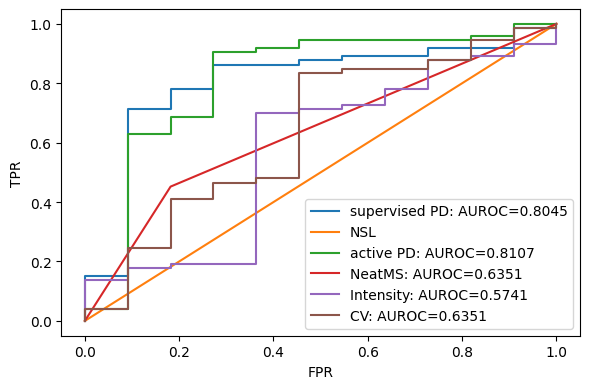

In [140]:
makeROCPlot(y_test_scores_supervised[:,1],y_test[:,1],noSkill=True,label="supervised PD")
makeROCPlot(y_test_scores_active_syn[:,1],y_test[:,1],noSkill=False,label="active PD")
makeROCPlot(y_test_scores_neat_ms,y_test[:,1],noSkill=False,label="NeatMS")
makeROCPlot(predInt,y_test[:,1],noSkill=False,label="Intensity")
makeROCPlot(predCV,trueCV,noSkill=False,label="CV")
plt.tight_layout()
plt.savefig(datadir+"ROC.png",dpi=300)

In [141]:
acc_results = {"active PD":{},"NeatMS":{}}

for metricFunc,name in zip([met.accuracy_score,met.precision_score,met.recall_score],["accuracy","precision","recall"]):
    acc_results["active PD"][name] = metricFunc(y_test[:,1],y_test_scores_active_syn[:,1] > cutoff)
    acc_results["NeatMS"][name] = metricFunc(y_test[:,1],y_test_scores_neat_ms > 0.25)

acc_results = pd.DataFrame.from_dict(acc_results,orient="index")
acc_results.to_csv(datadir + "accuracy_results.csv")
acc_results

accuracy  precision    recall
active PD  0.857143   0.886076  0.958904
NeatMS     0.500000   0.942857  0.452055

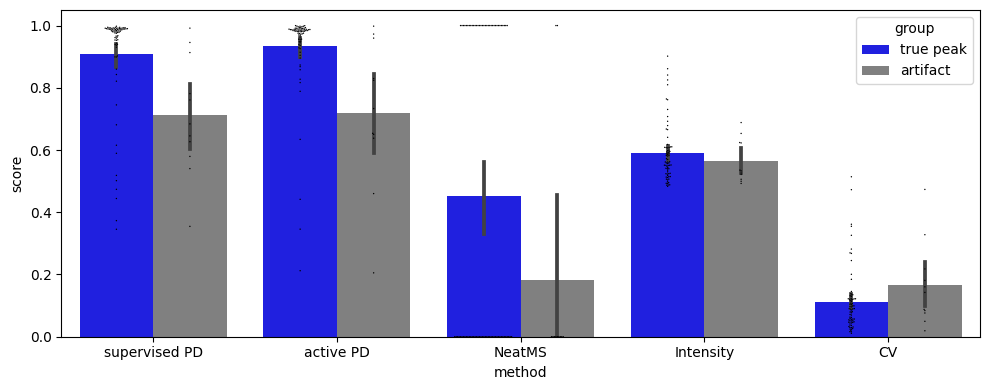

In [142]:
plt_df = {}
for x in range(len(y_test)):
    if y_test[x][1] > cutoff:
        plt_df[len(plt_df)] = {"method":"supervised PD","group":"true peak","score":y_test_scores_supervised[x][1]}
        plt_df[len(plt_df)] = {"method":"active PD","group":"true peak","score":y_test_scores_active_syn[x][1]}
        plt_df[len(plt_df)] = {"method":"NeatMS","group":"true peak","score":y_test_scores_neat_ms[x]}
        plt_df[len(plt_df)] = {"method":"Intensity","group":"true peak","score":np.log10(predInt[x]+2)/10}
    else:
        plt_df[len(plt_df)] = {"method":"supervised PD","group":"artifact","score":y_test_scores_supervised[x][1]}
        plt_df[len(plt_df)] = {"method":"active PD","group":"artifact","score":y_test_scores_active_syn[x][1]}
        plt_df[len(plt_df)] = {"method":"NeatMS","group":"artifact","score":y_test_scores_neat_ms[x]}
        plt_df[len(plt_df)] = {"method":"Intensity","group":"artifact","score":np.log10(predInt[x]+2)/10}
for x in range(len(predCV)):
    if trueCV[x] > 0.5:
        plt_df[len(plt_df)] = {"method":"CV","group":"true peak","score":1-predCV[x]}
    else:
        plt_df[len(plt_df)] = {"method":"CV","group":"artifact","score":1-predCV[x]}

plt_df = pd.DataFrame.from_dict(plt_df,orient="index")
plt.figure(figsize=(10,4))
#sb.violinplot(data=plt_df,x="method",y="score",hue="group",cut=0,palette={"true peak":"blue","artifact":"grey"})
#sb.boxplot(data=plt_df,x="method",y="score",hue="group",fliersize=0,palette={"true peak":"blue","artifact":"grey"})
sb.barplot(data=plt_df,x="method",y="score",hue="group",palette={"true peak":"blue","artifact":"grey"})
sb.swarmplot(data=plt_df,x="method",y="score",hue="group",palette={"true peak":"black","artifact":"black"},dodge=True,s=1,legend=False)
plt.tight_layout()
plt.savefig(datadir+"bar.png",dpi=300)

In [143]:
y = integ.classifyMatrix(X)

7040/7040 [==============================] - 9s 1ms/step


c:\users\ethan\appdata\local\programs\python\python37\lib\site-packages\seaborn\matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


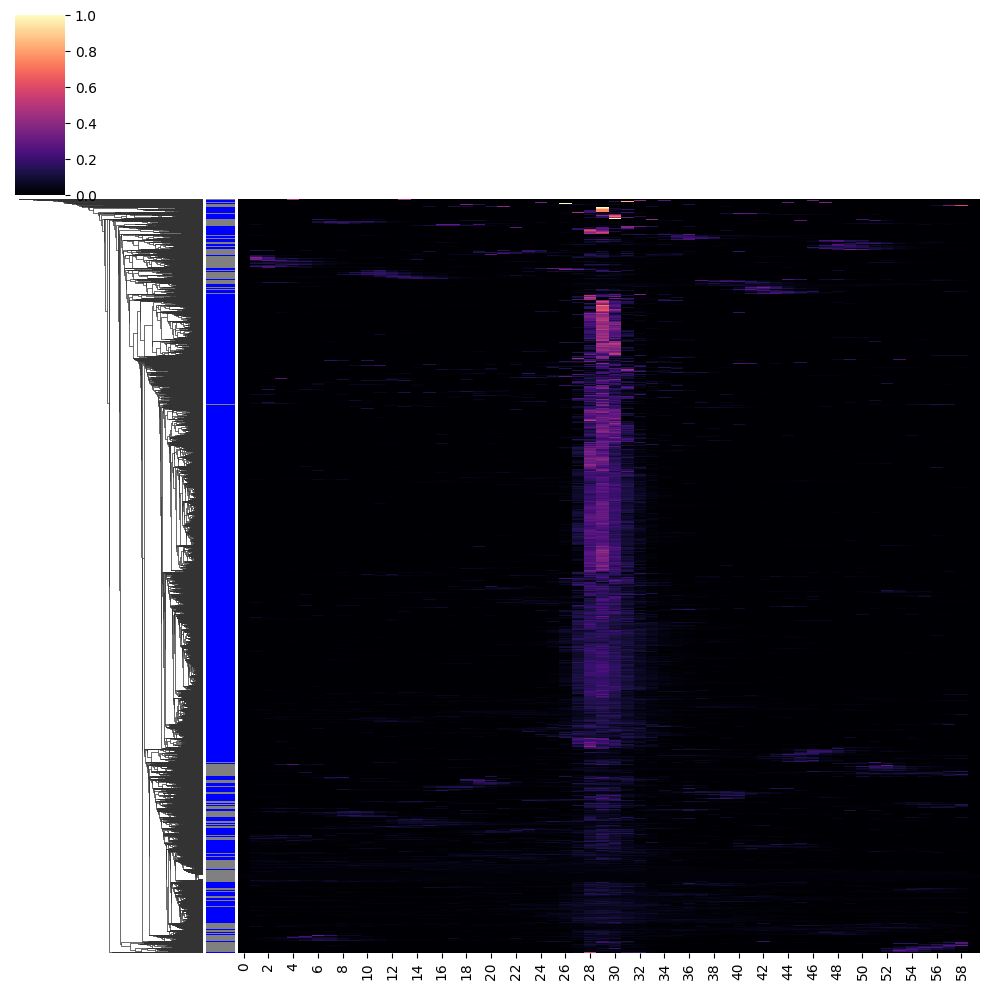

In [144]:
def tmp(val):
    if val > cutoff:
        return "blue"
    return "grey"
row_colors = [tmp(x) for x in y[:len(peakList),1]]
f = sb.clustermap(PeakDetective.normalizeMatrix(X[:len(peakList)]),col_cluster=False,yticklabels=False,cmap="magma",vmin=0.0,vmax=1.0,row_colors=row_colors)
f.savefig(datadir + "heatmap.png",dpi=300)

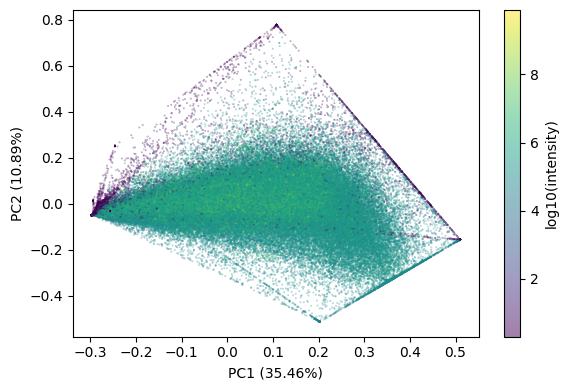

In [145]:
pca = PCA(2)
loads = pca.fit_transform(PeakDetective.normalizeMatrix(X))
plt.scatter(loads[:,0],loads[:,1],c=np.log10(np.array([np.max([2, PeakDetective.integratePeak(x)]) for x in X])),s=.1,alpha=.5)
plt.xlabel("PC1 (" + str(np.round(100*pca.explained_variance_ratio_[0],2)) + "%)")
plt.ylabel("PC2 (" + str(np.round(100*pca.explained_variance_ratio_[1],2)) + "%)")
#plt.xlim((-.5,.5))
plt.colorbar(label="log10(intensity)")
plt.tight_layout()
plt.savefig(datadir + "pca_int.png",dpi=300)

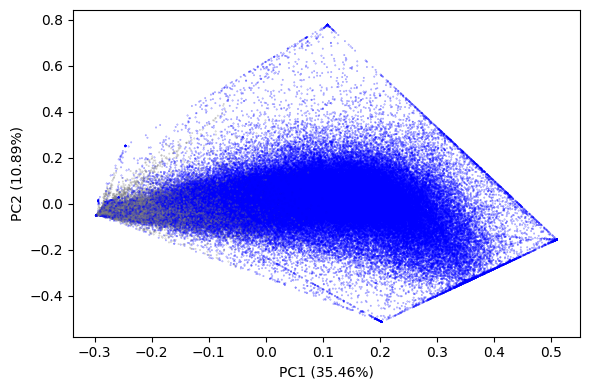

In [146]:
pca = PCA(2)
loads = pca.fit_transform(PeakDetective.normalizeMatrix(X))
colormap = LinearSegmentedColormap.from_list("test",colors=["grey", "blue"],N=256)
def getColor(v):
    if v > cutoff:
        return "blue"
    else:
        return "grey"
colors = [getColor(x) for x in y[:,1]]
#plt.scatter(loads[:,0],loads[:,1],c=y[:,1],s=.1,alpha=.5,cmap=colormap)
plt.scatter(loads[:,0],loads[:,1],c=colors,s=.1,alpha=.5)

plt.xlabel("PC1 (" + str(np.round(100*pca.explained_variance_ratio_[0],2)) + "%)")
plt.ylabel("PC2 (" + str(np.round(100*pca.explained_variance_ratio_[1],2)) + "%)")
#plt.xlim((-.5,.5))

#plt.colorbar(label="PeakDetective Score")
plt.tight_layout()
plt.savefig(datadir + "pca_pd.png",dpi=300)

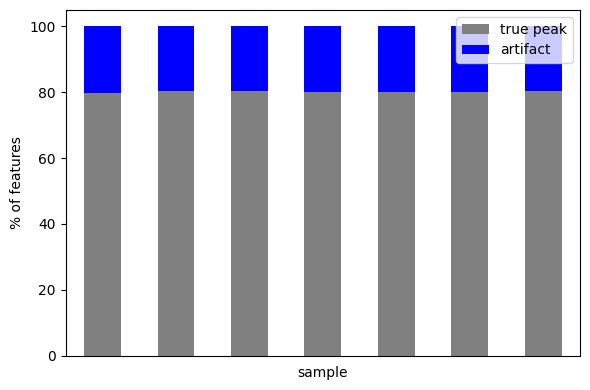

In [147]:
df = {}
for file in files:
    for index,row in peak_curated.iterrows():
        if row[datadir + file] > cutoff:
            df[len(df)] = {"sample":file,"classification":"true peak"}
        else:
            df[len(df)] = {"sample":file,"classification":"artifact"}

df = pd.DataFrame.from_dict(df,orient="index")

def aggregate(rows,columns,df):
    column_keys = df[columns].unique()
    row_keys = df[rows].unique()

    agg = { key : [ 100*len(df[(df[rows]==value) & (df[columns]==key)]) / len(df[df[rows]==value]) for value in row_keys]
               for key in column_keys }

    aggdf = pd.DataFrame(agg,index = row_keys)
    aggdf.index.rename(rows,inplace=True)

    return aggdf


aggregate('sample','classification',df).plot(kind='bar',stacked=True,color=["grey","blue"])
plt.xticks([],[])
plt.ylabel("% of features")
plt.tight_layout()
plt.savefig(datadir + "bar_pd_arts.png",dpi=300)

['QC_01.mzML', 'QC_02.mzML', 'QC_03.mzML', 'QC_04.mzML', 'QC_05.mzML', 'QC_06.mzML', 'QC_07.mzML']


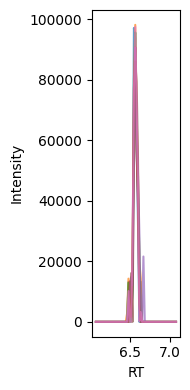

In [148]:


file = files[0]
print(files)
inds = list(peak_curated.index.values)
rd.shuffle(inds)
plt.figure(figsize=(2,4))
for i in inds:
    if peak_curated.at[i,datadir + file] > cutoff:
        plot_overlayedEIC(raw_data,peak_curated.at[i,"mz"],peak_curated.at[i,"rt"]-.5,peak_curated.at[i,"rt"]+.5,resolution=resolution,alpha=0.7)
        plt.xlabel("RT")
        plt.ylabel("Intensity")
        break
plt.tight_layout()
plt.savefig(datadir + "true_peak_example.png",dpi=300)


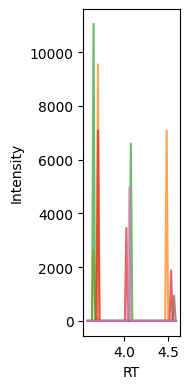

In [149]:
rd.shuffle(inds)
plt.figure(figsize=(2,4))
for i in inds:
    if peak_curated.at[i,datadir + file] < cutoff:
        plot_overlayedEIC(raw_data,peak_curated.at[i,"mz"],peak_curated.at[i,"rt"]-.5,peak_curated.at[i,"rt"]+.5,resolution=resolution,alpha=0.7)
        plt.xlabel("RT")
        plt.ylabel("Intensity")
        break
plt.tight_layout()
plt.savefig(datadir + "artifact_example.png",dpi=300)

In [150]:
true = []
pred = []
file = files[0]
fps = []
fns = []
for index,row in peakList_labeled.iterrows():
    if peak_curated.at[index,datadir + file] > 0.5:
        pred.append(1.0)
        if row["classification"] < 0.5:
            fps.append(index)
    else:
        pred.append(0.0)
        if row["classification"] > .5:
            fns.append(index)
    true.append(row["classification"])
    
confusion_matrix(true,pred)

array([[ 49,  94],
       [ 40, 317]], dtype=int64)

c:\users\ethan\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:5: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  """


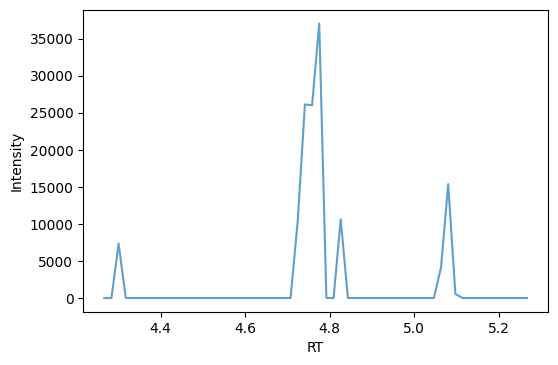

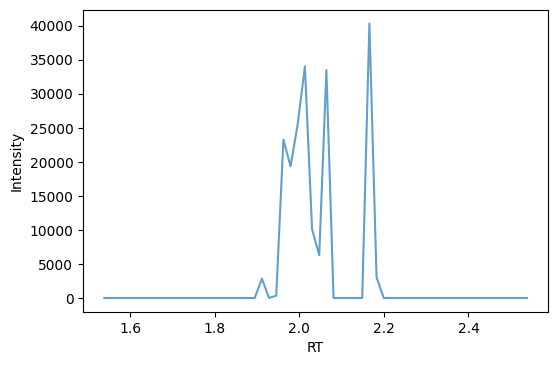

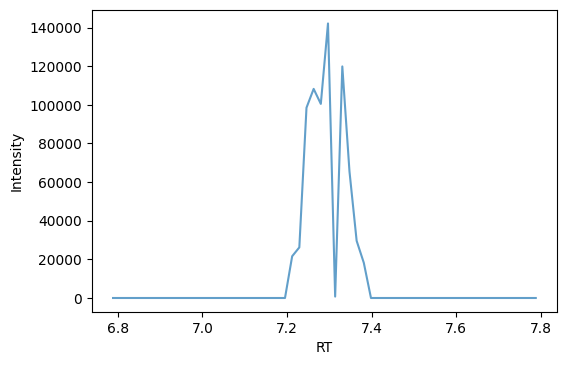

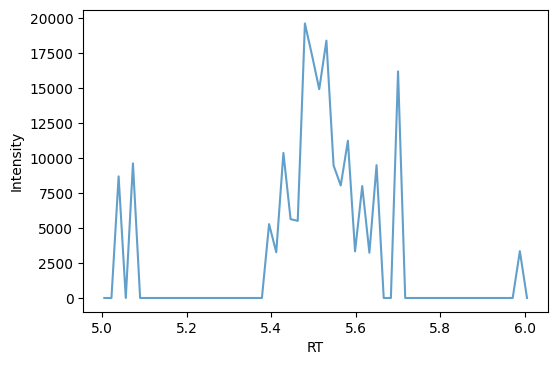

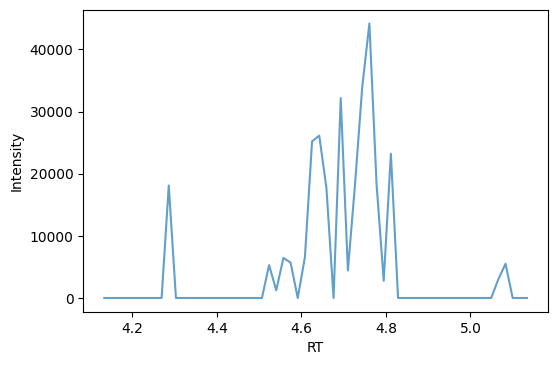

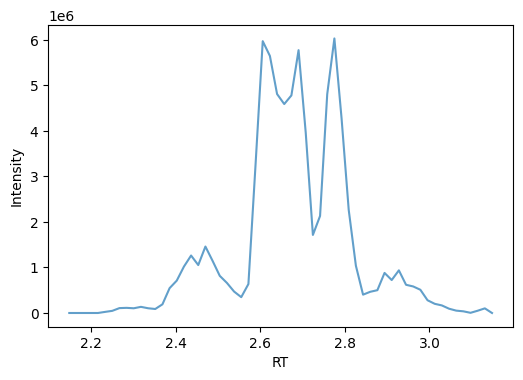

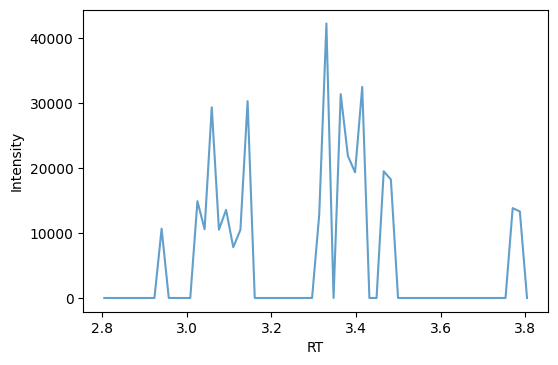

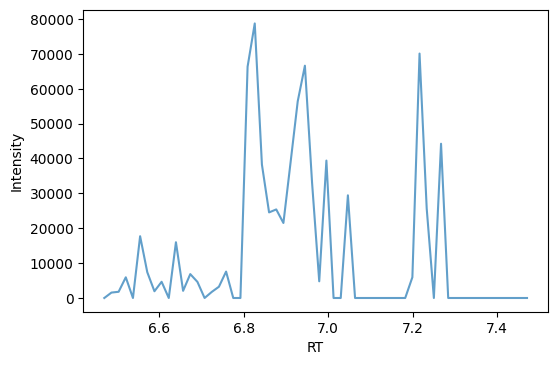

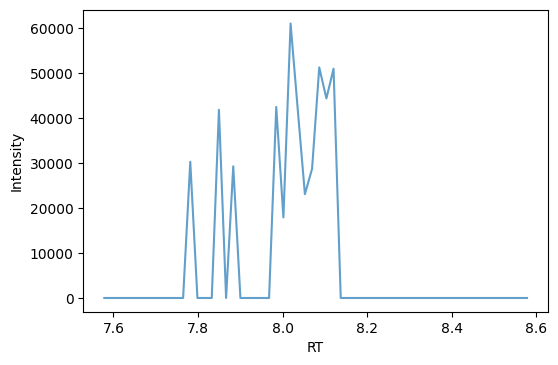

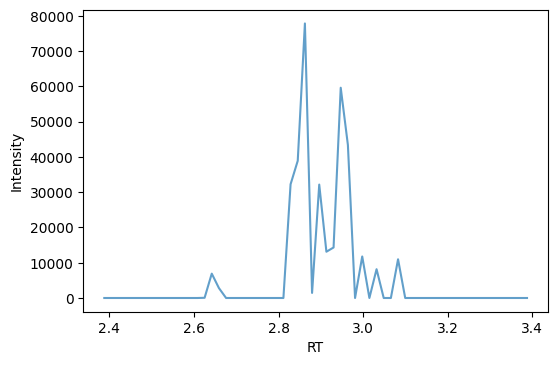

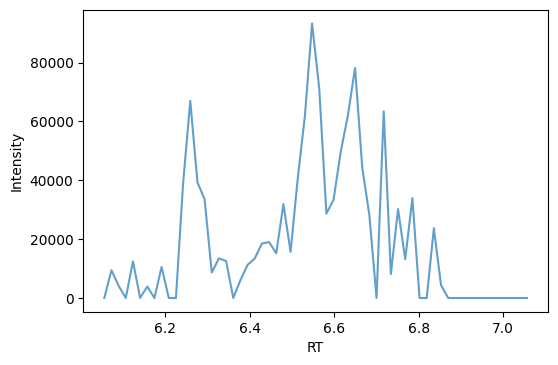

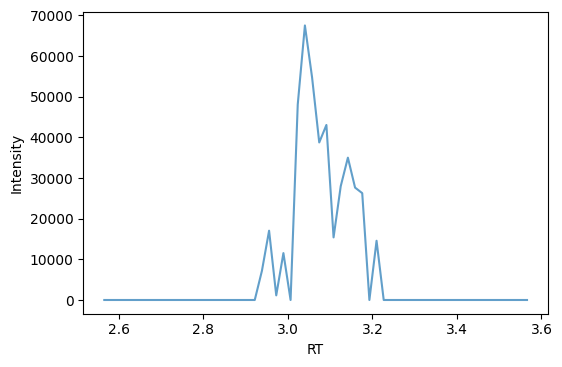

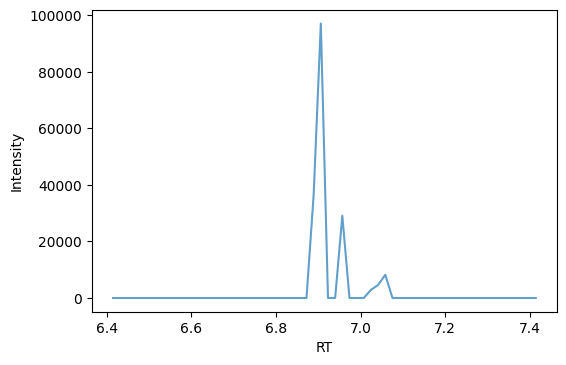

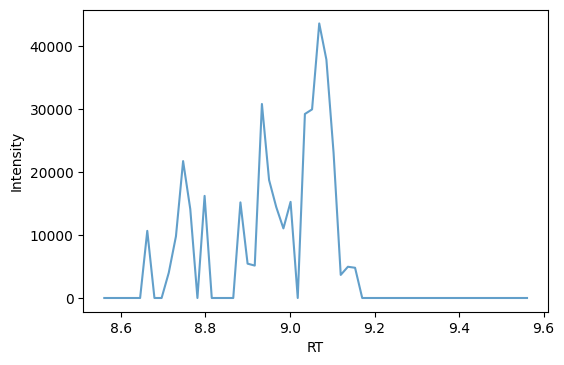

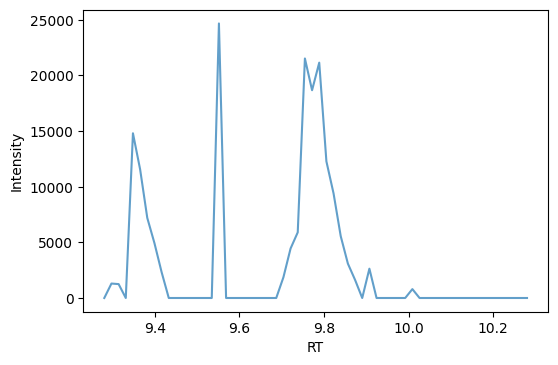

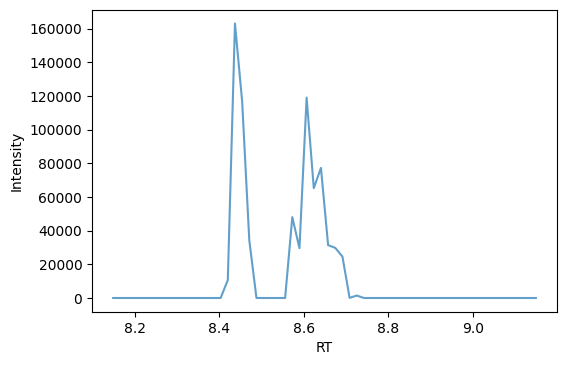

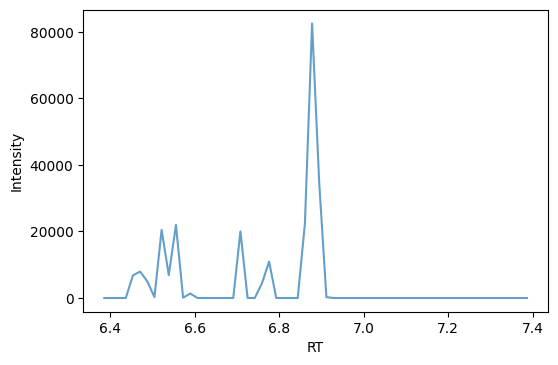

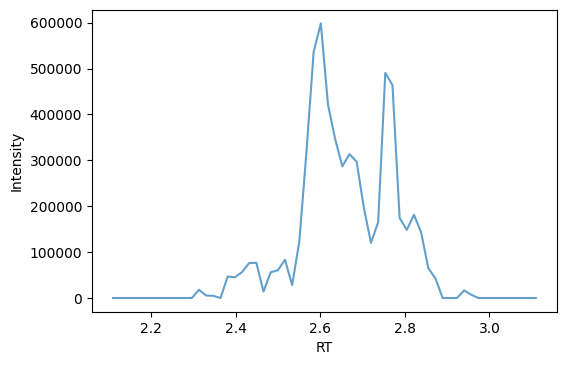

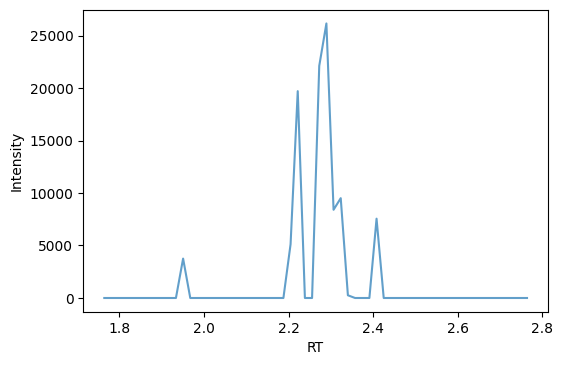

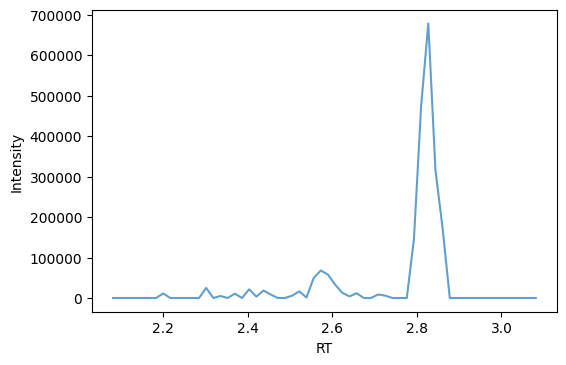

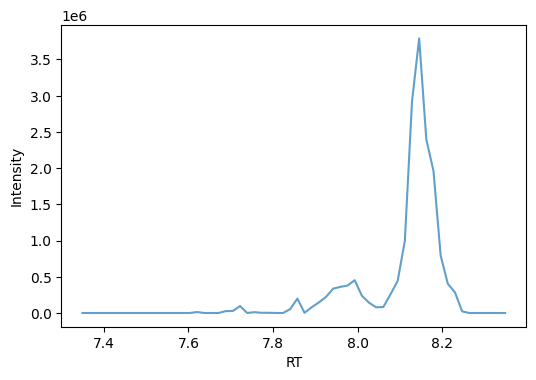

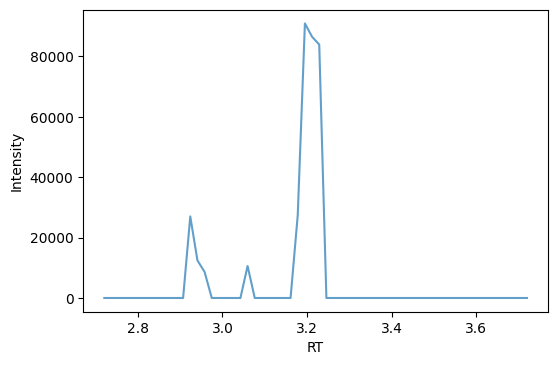

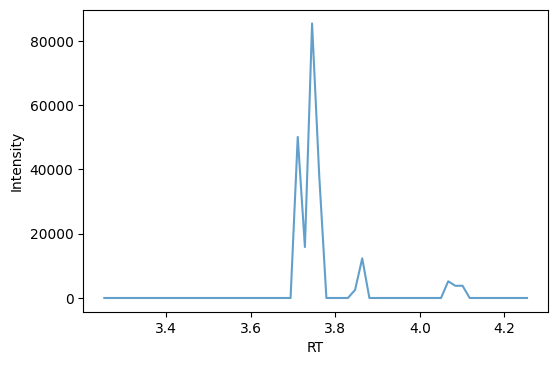

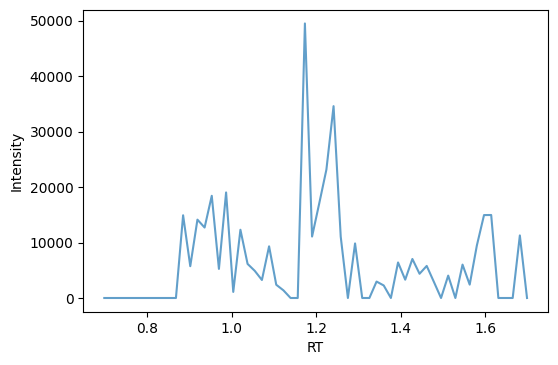

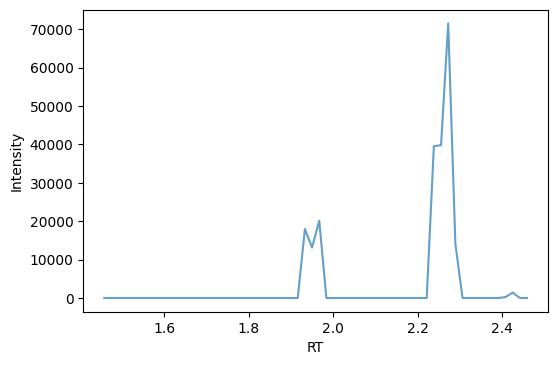

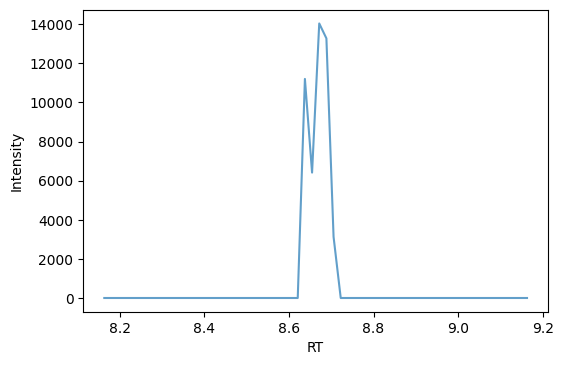

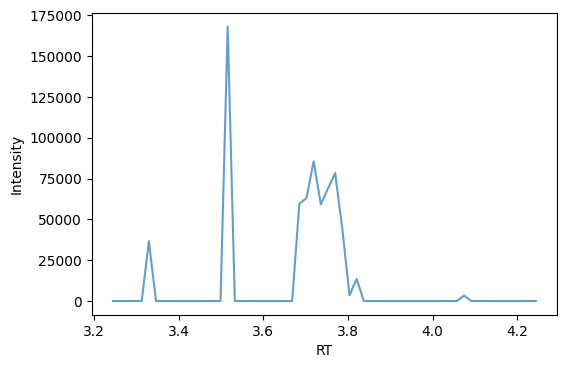

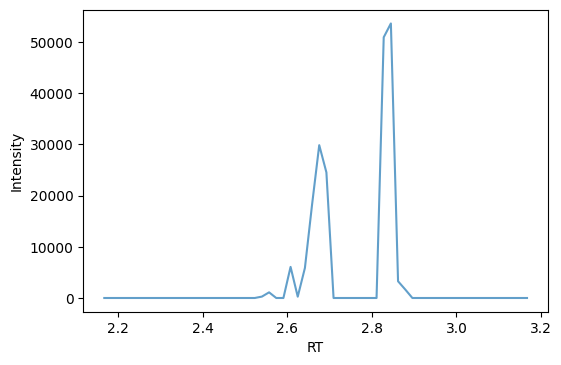

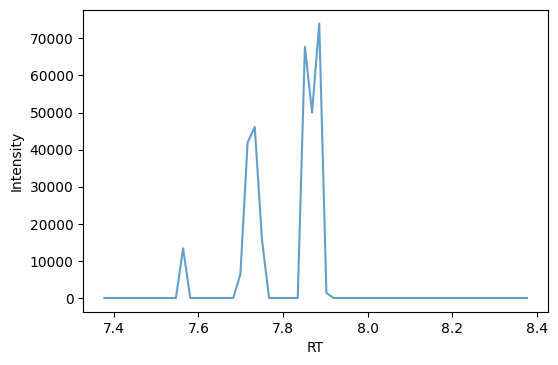

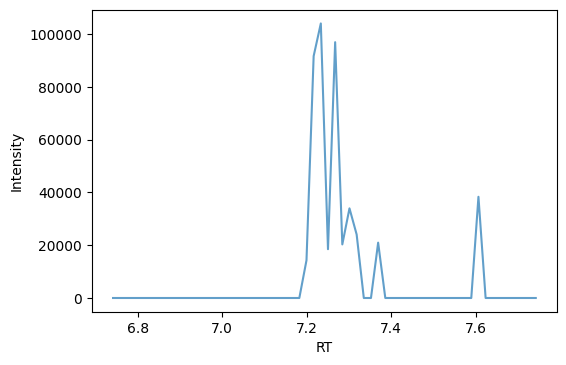

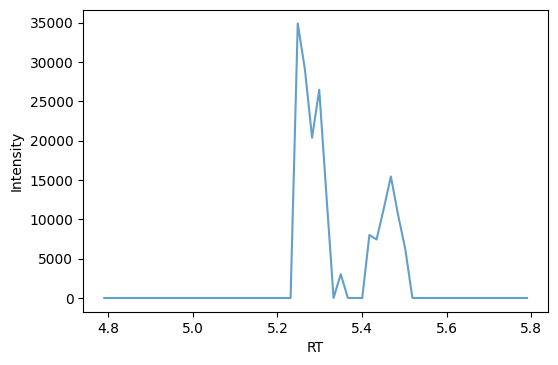

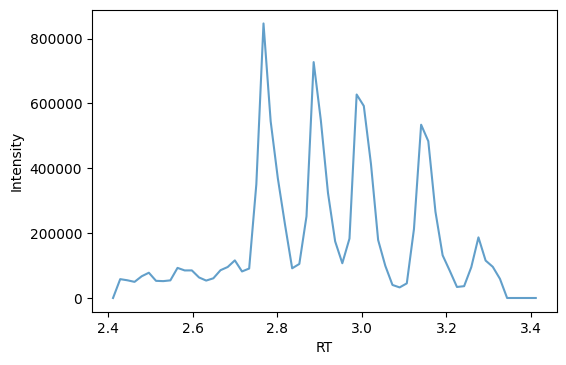

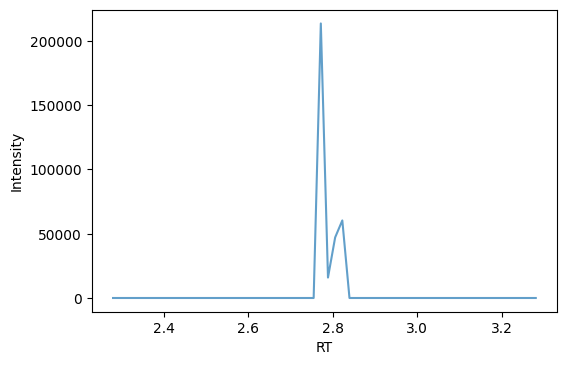

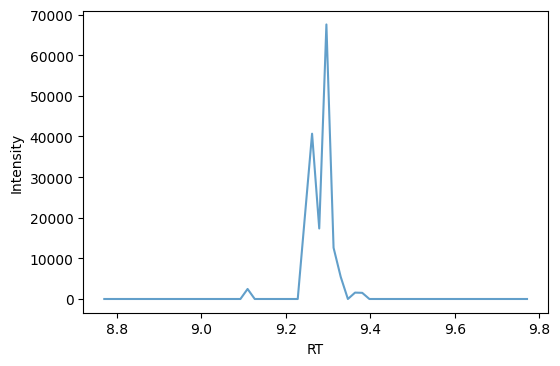

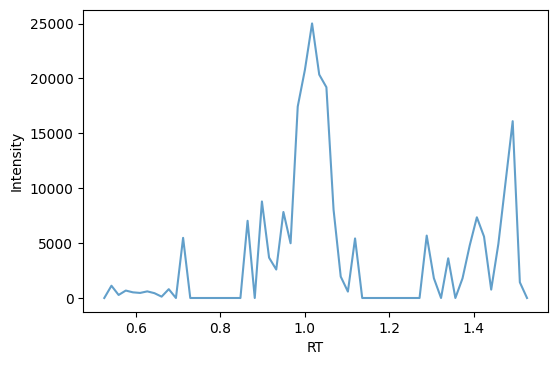

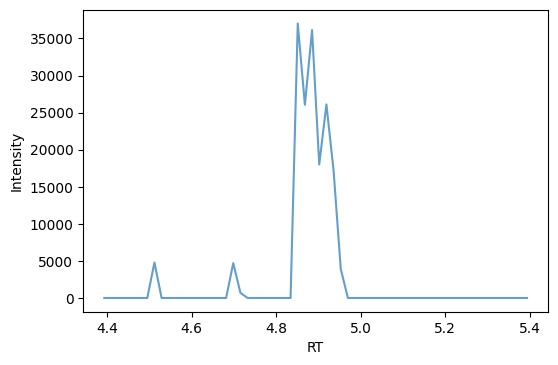

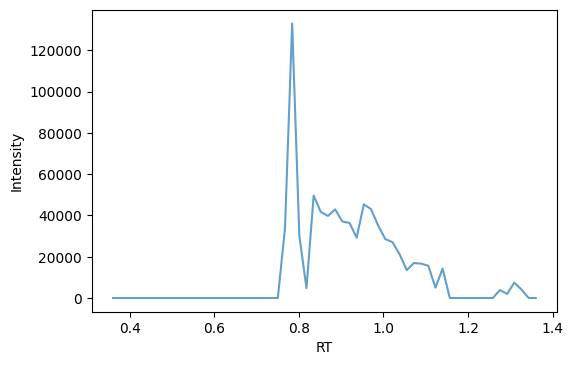

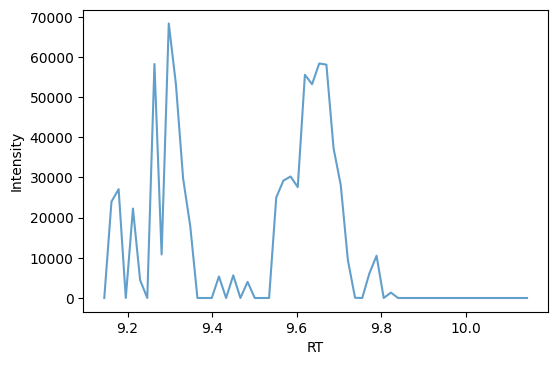

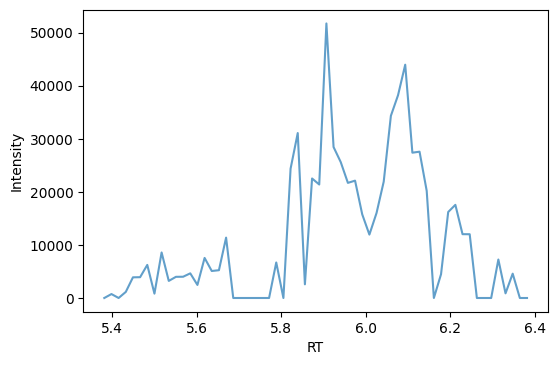

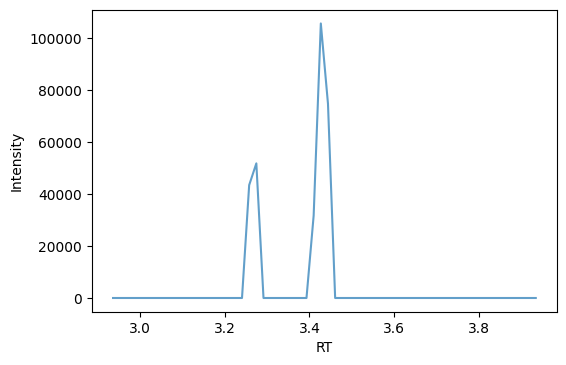

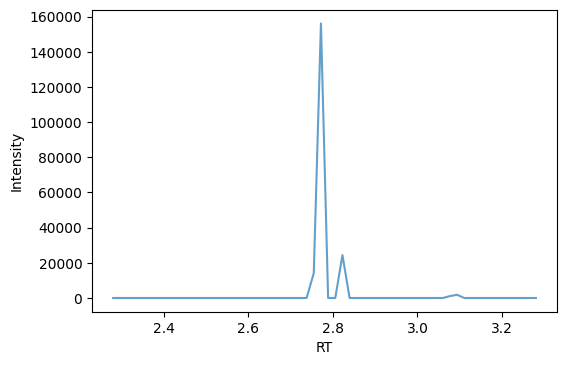

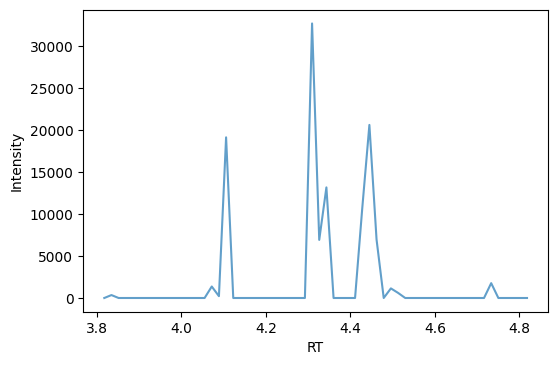

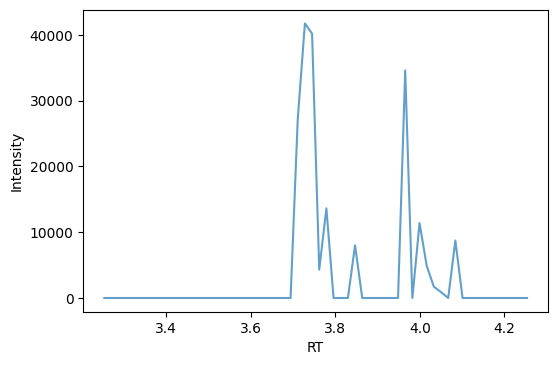

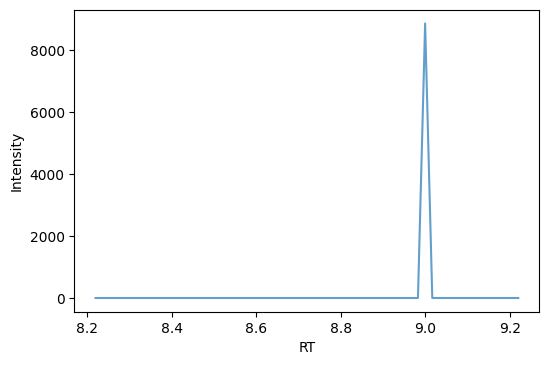

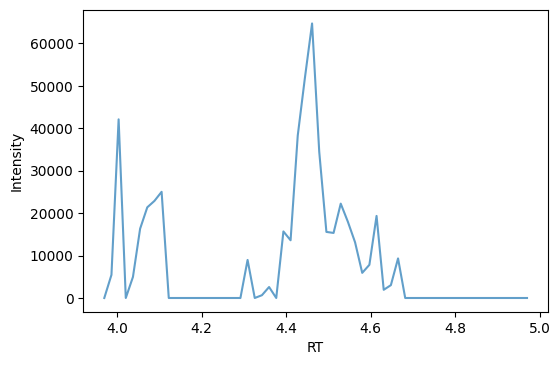

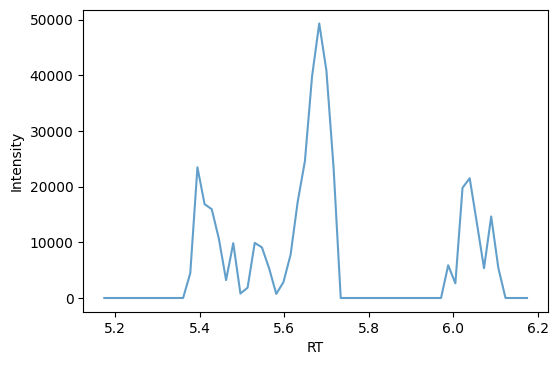

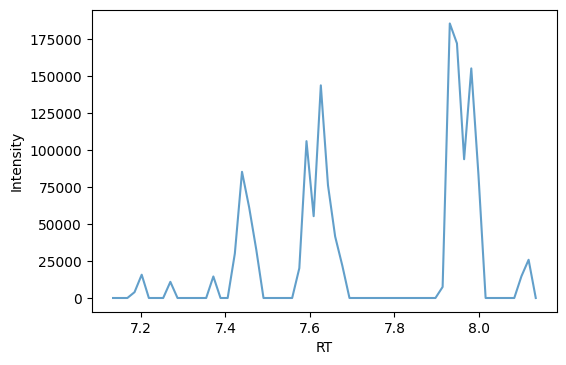

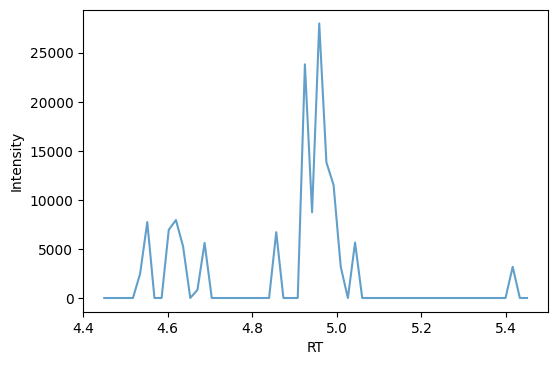

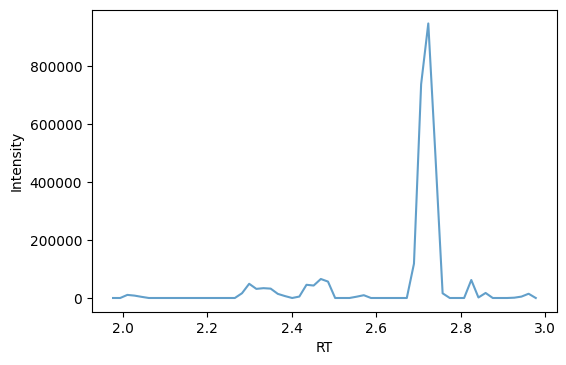

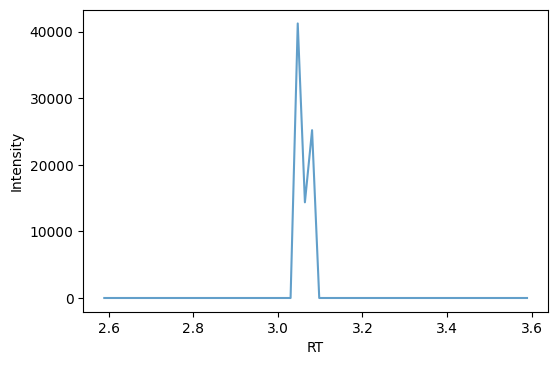

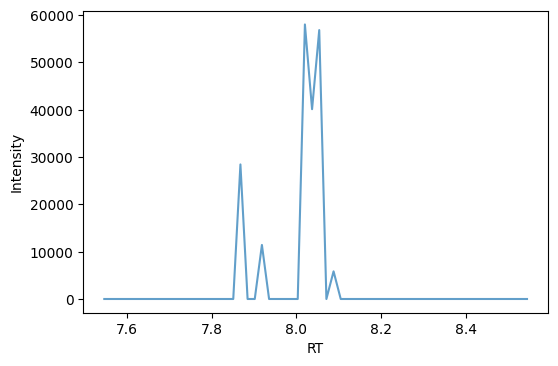

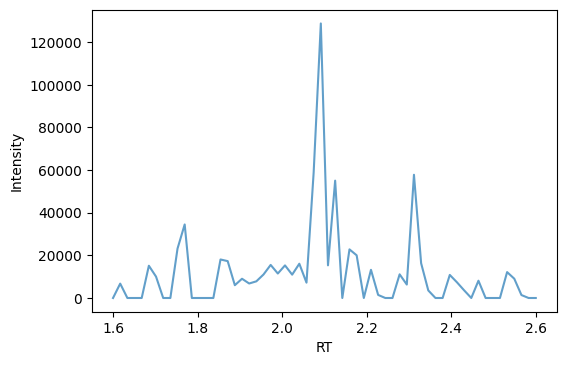

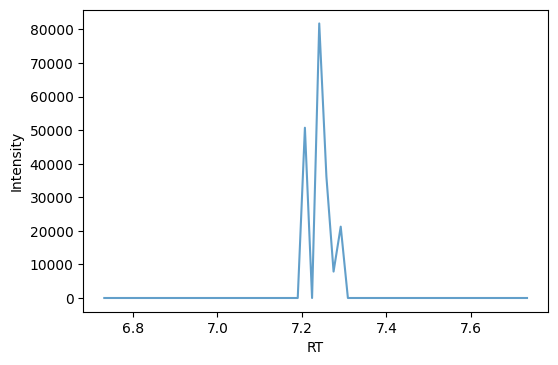

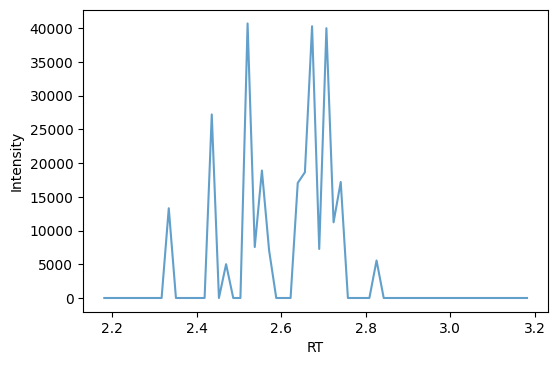

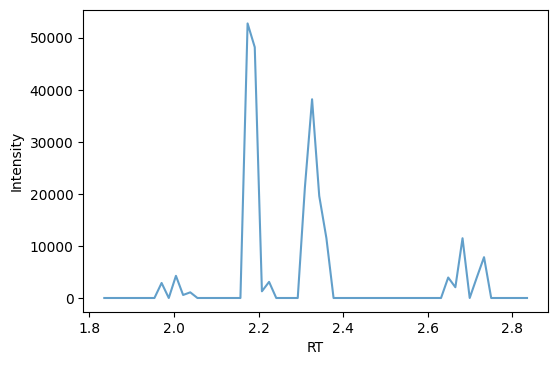

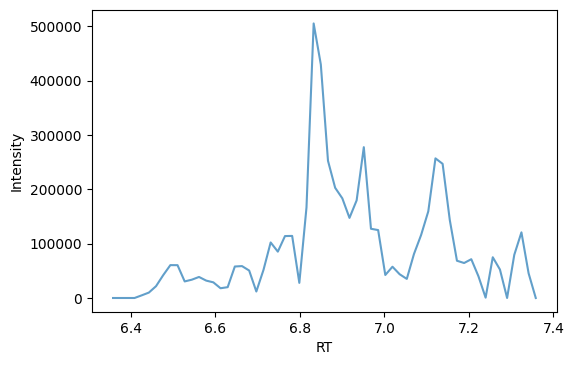

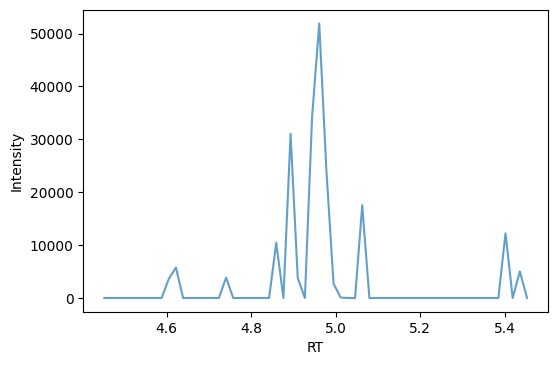

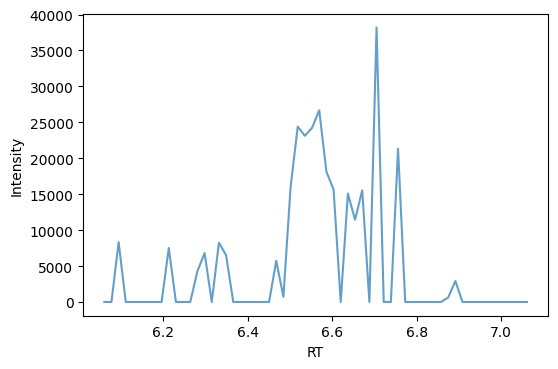

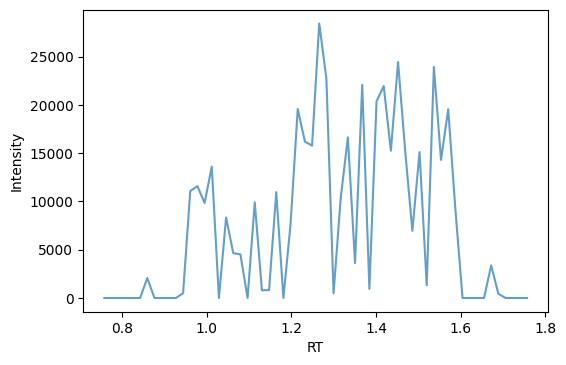

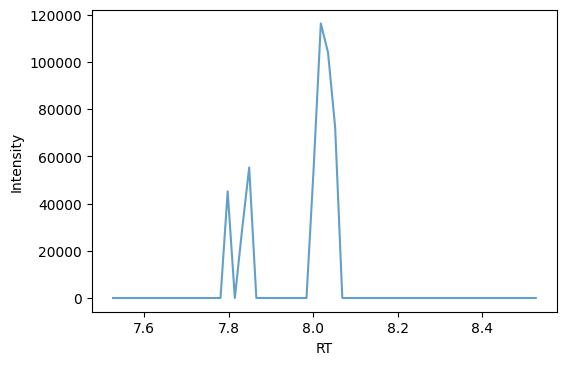

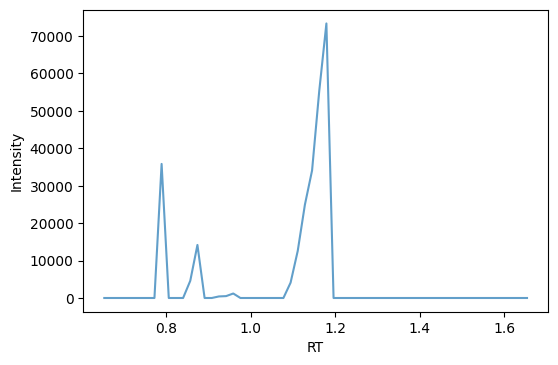

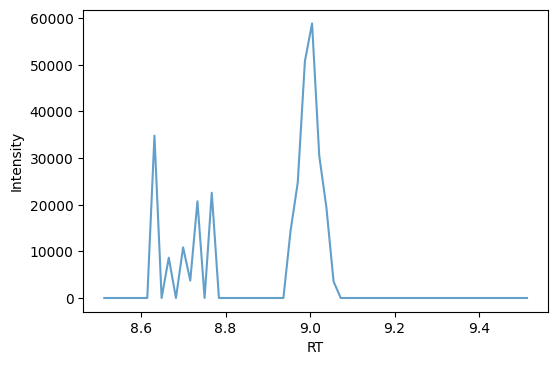

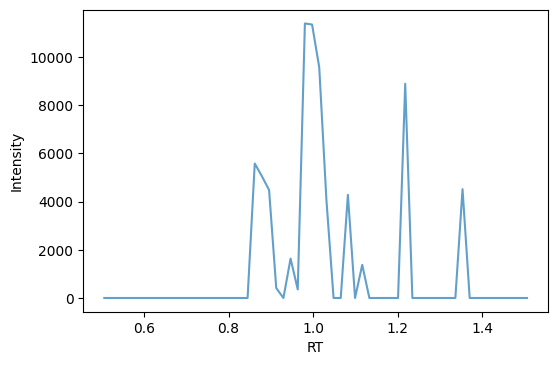

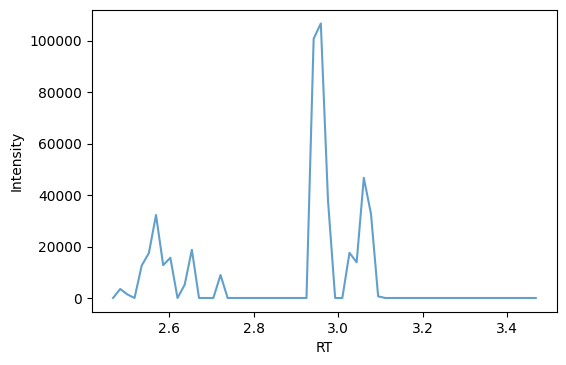

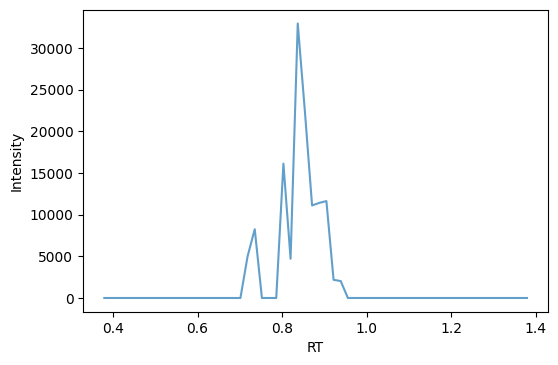

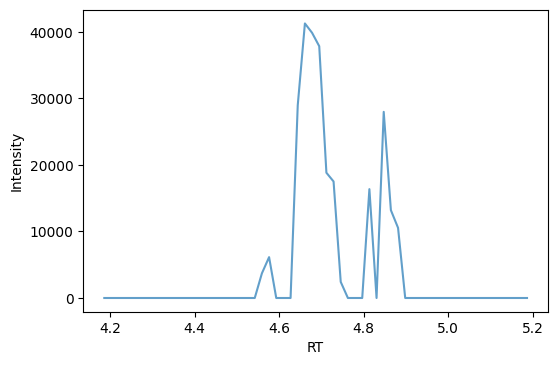

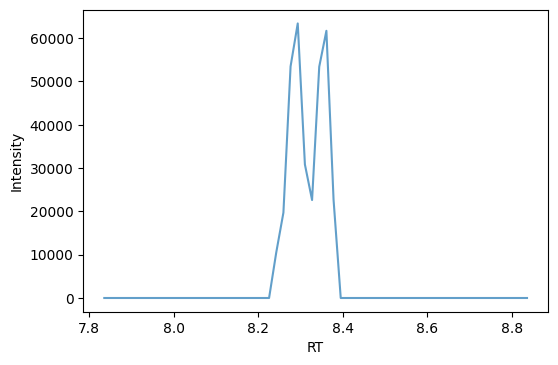

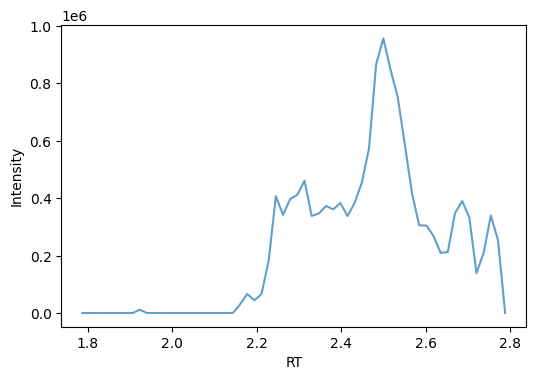

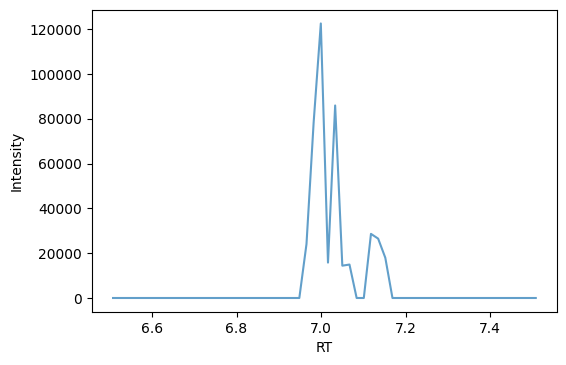

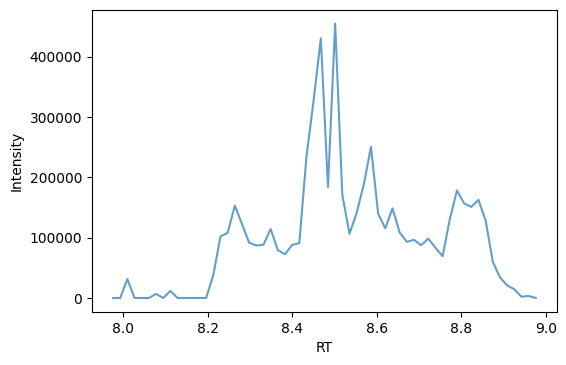

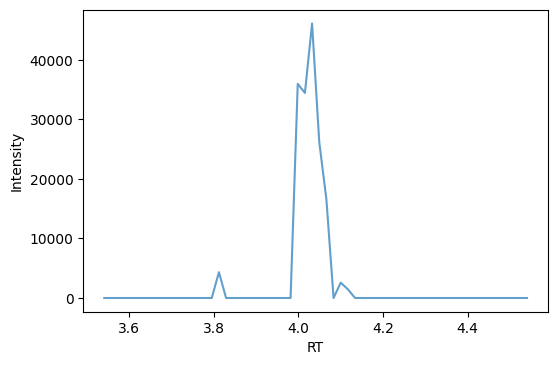

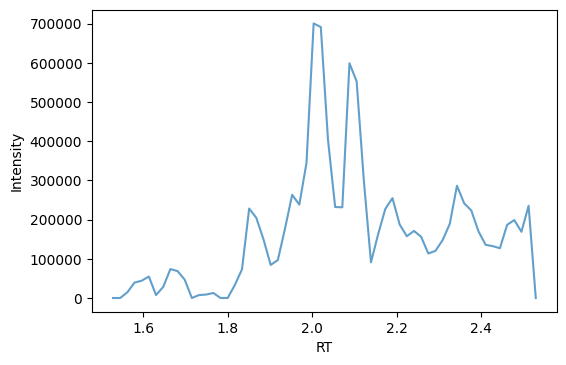

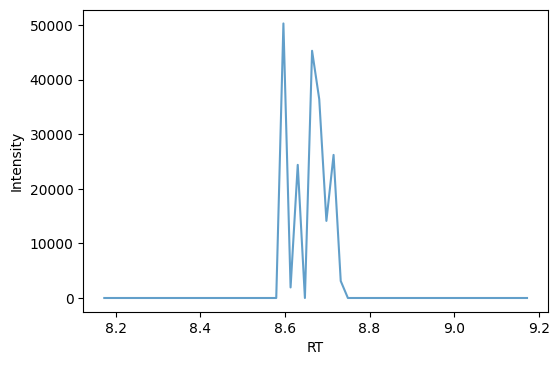

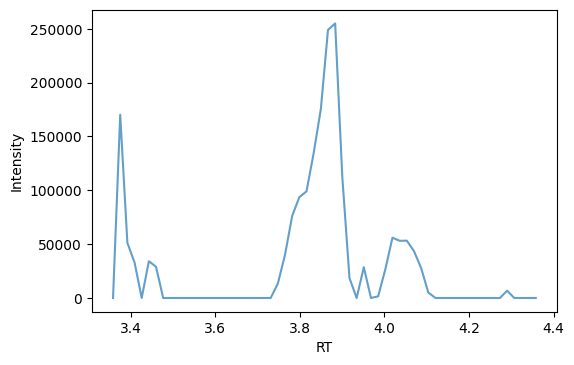

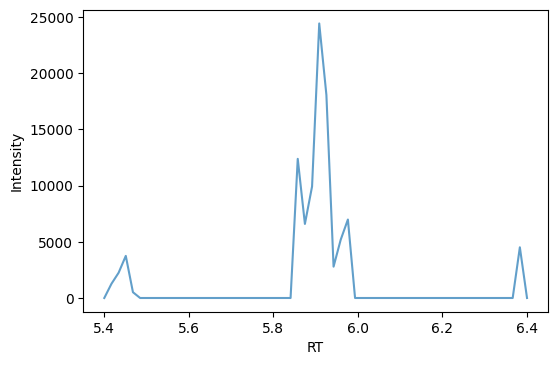

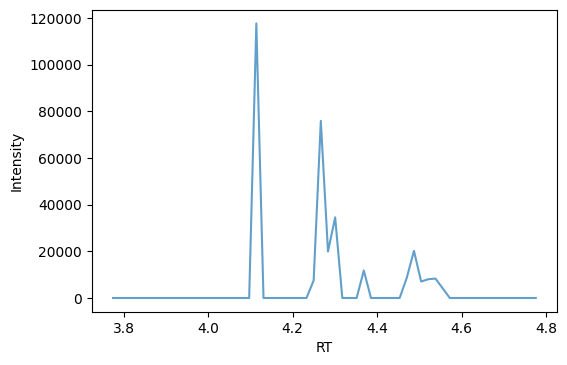

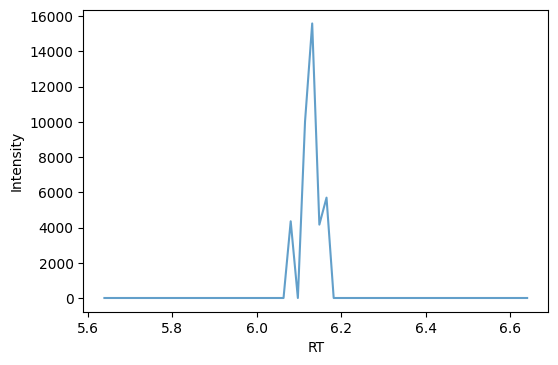

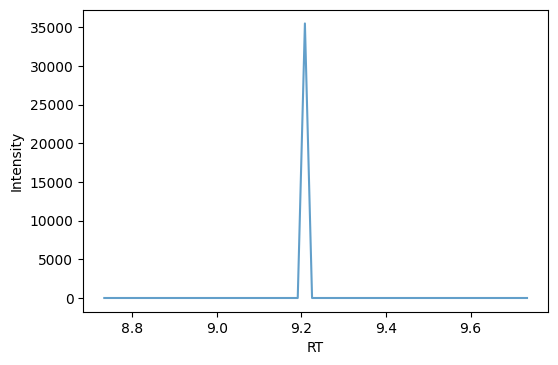

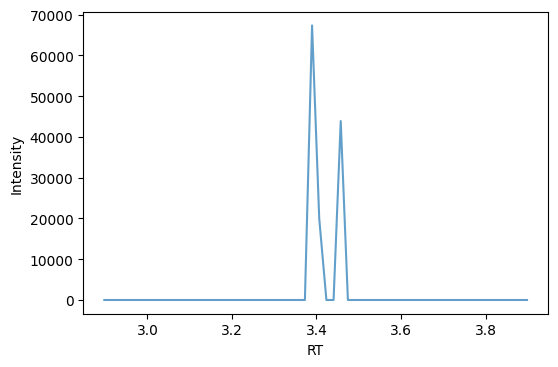

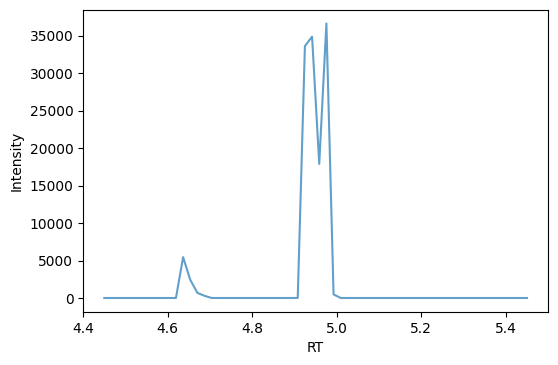

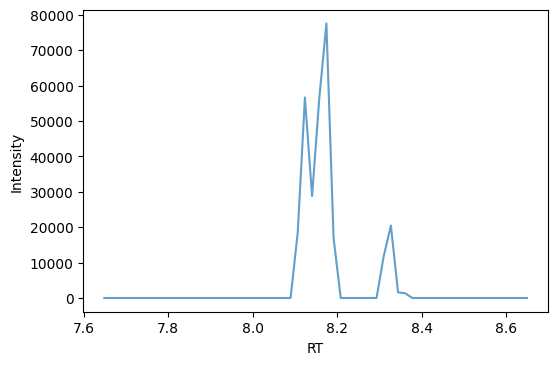

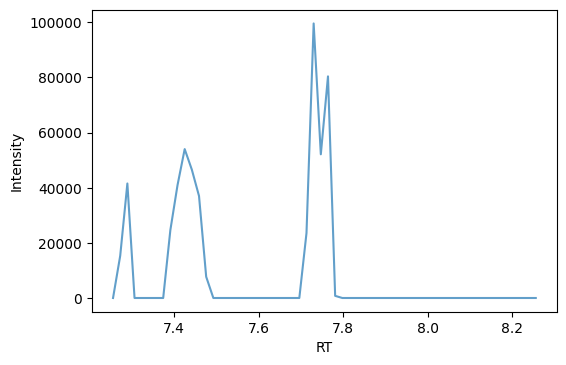

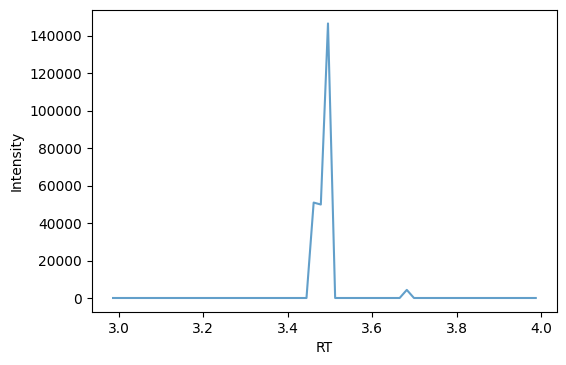

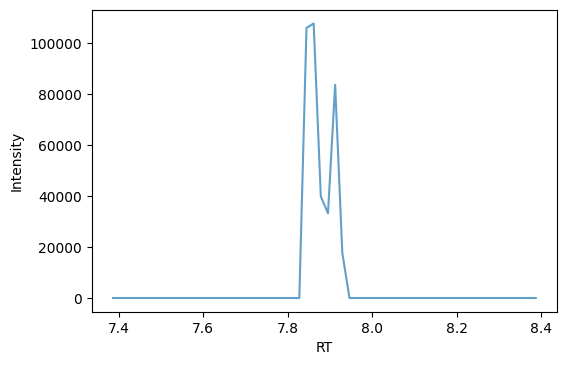

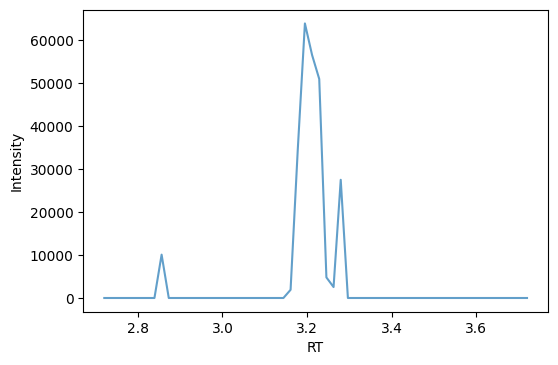

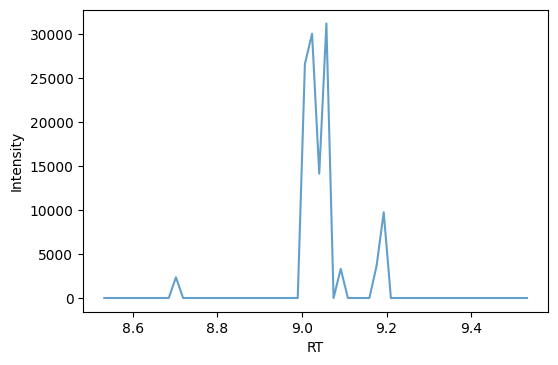

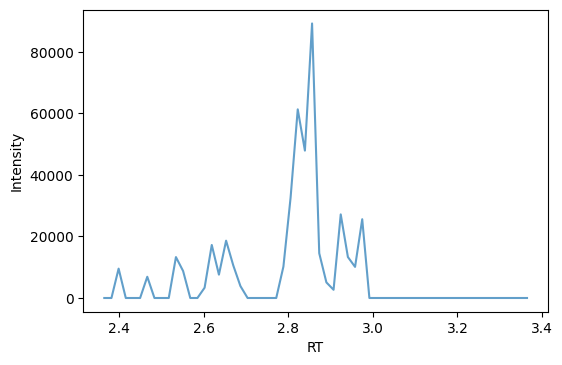

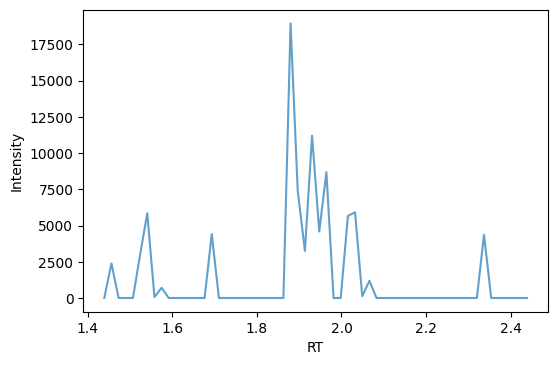

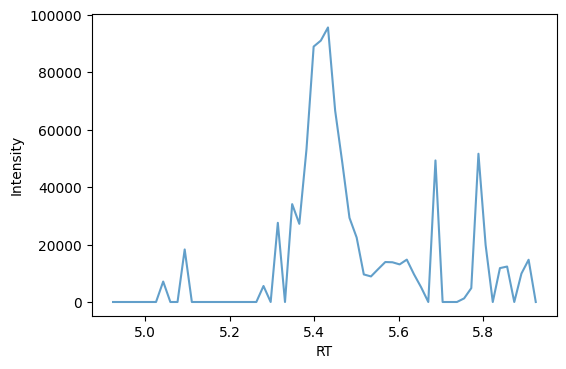

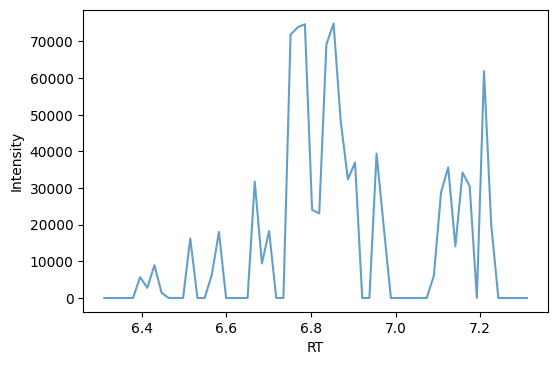

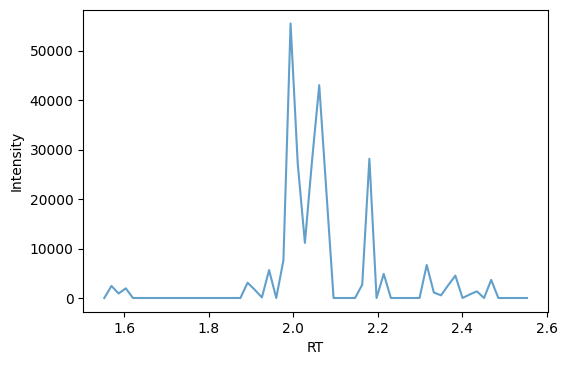

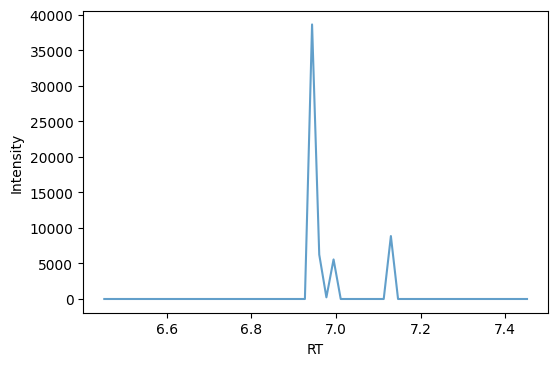

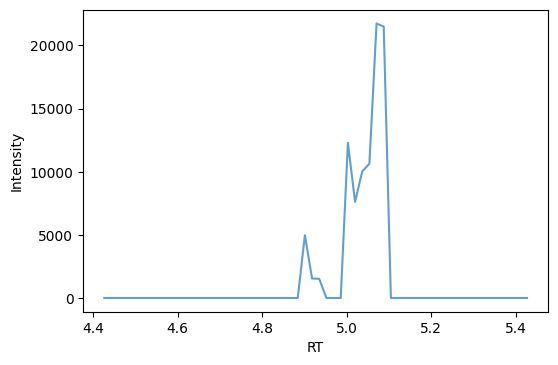

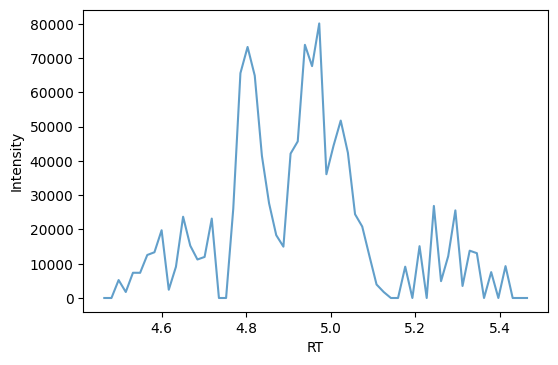

<Figure size 600x400 with 0 Axes>

In [151]:
for ind in fps:
    plot_overlayedEIC(raw_data[:1],peak_curated.at[ind,"mz"],peak_curated.at[ind,"rt"]-.5,peak_curated.at[ind,"rt"] + .5,resolution=resolution,alpha=0.7)
    plt.xlabel("RT")
    plt.ylabel("Intensity")
    plt.figure()

c:\users\ethan\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:5: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  """


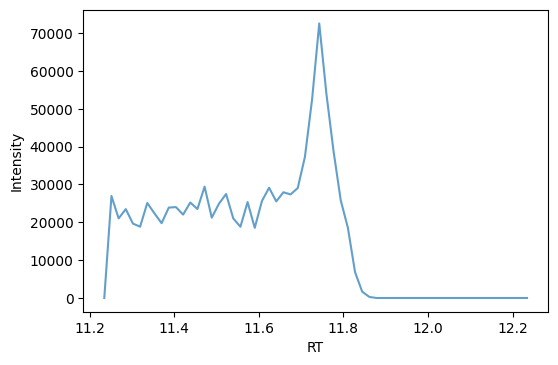

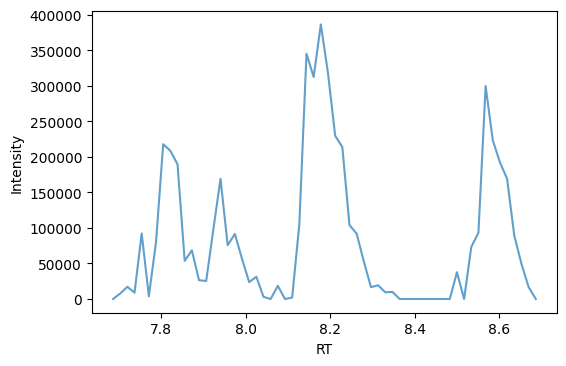

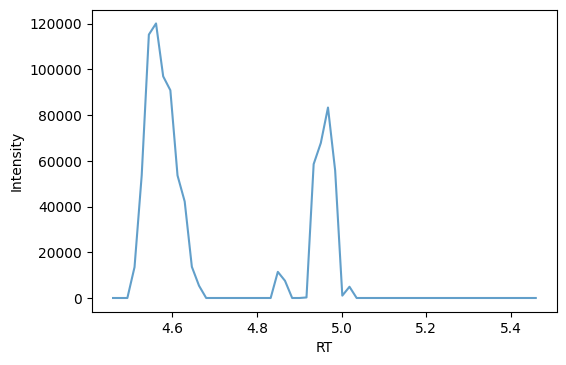

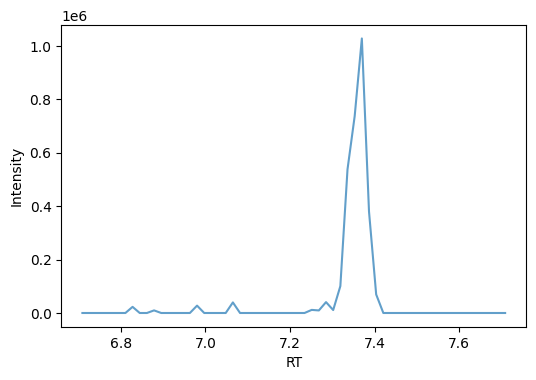

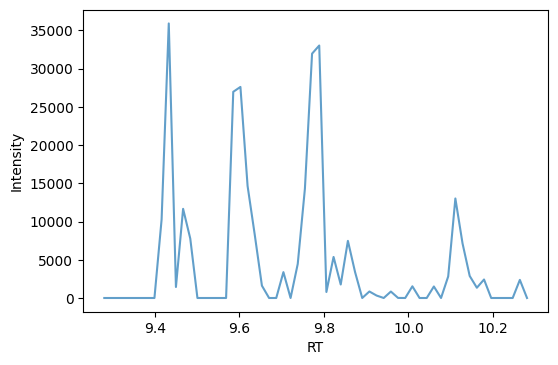

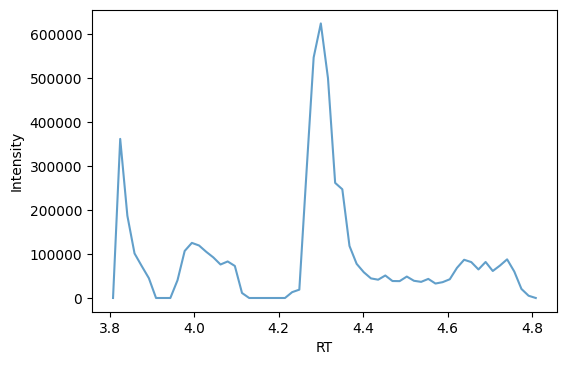

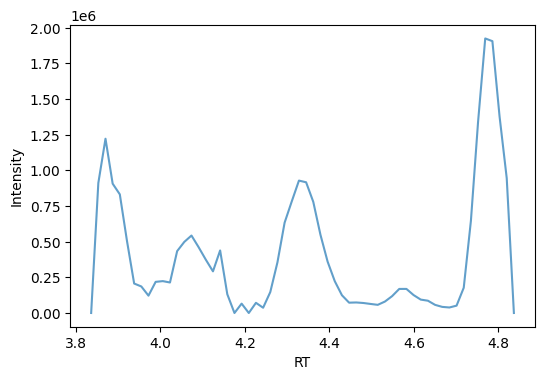

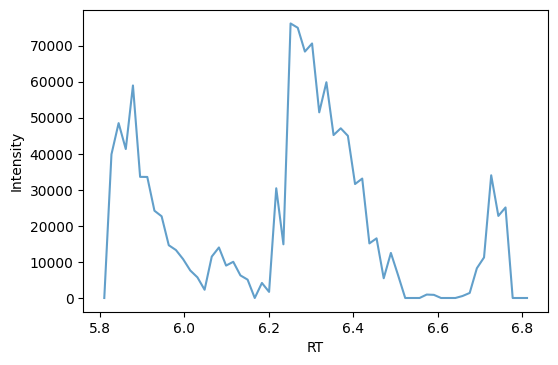

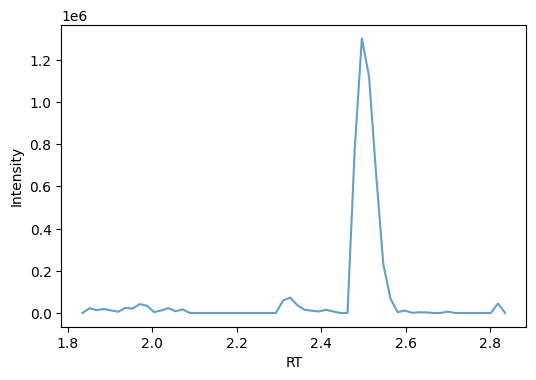

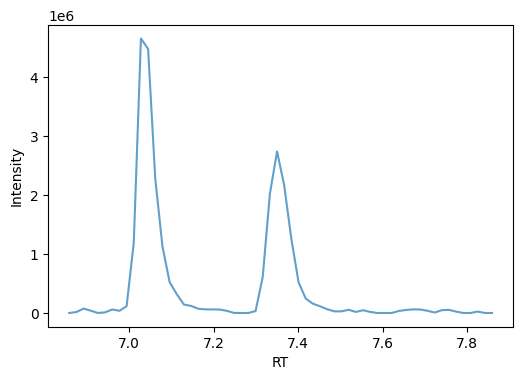

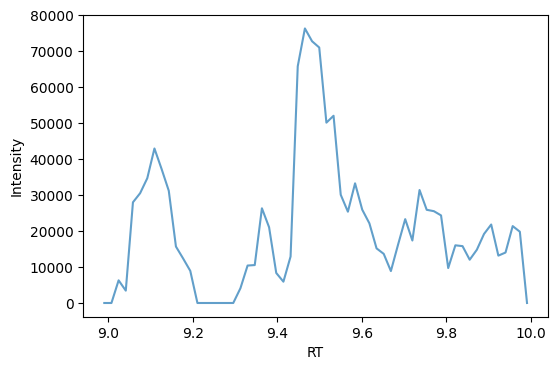

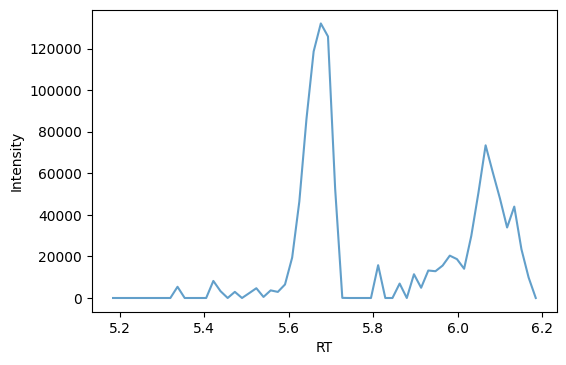

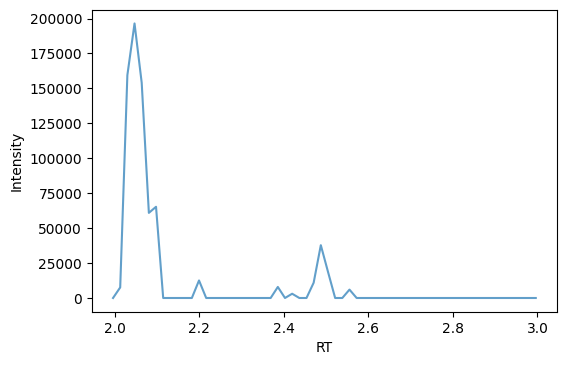

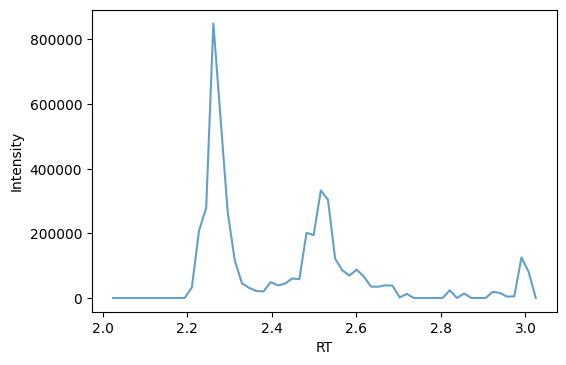

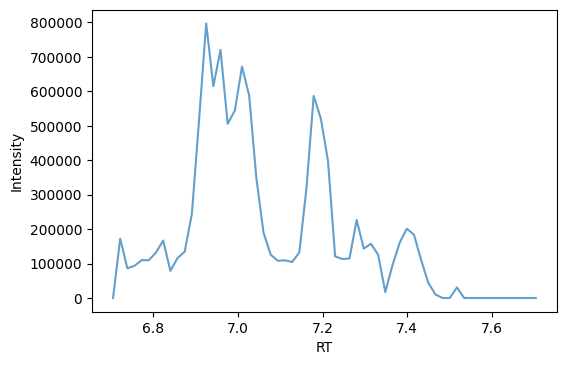

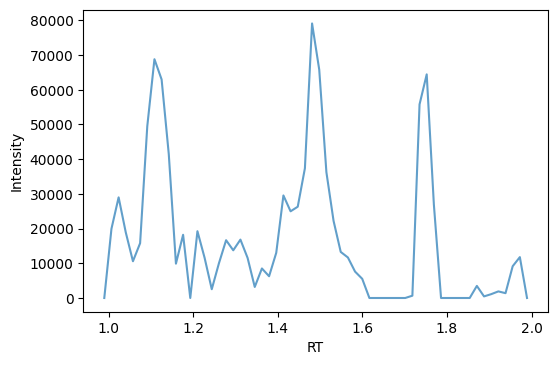

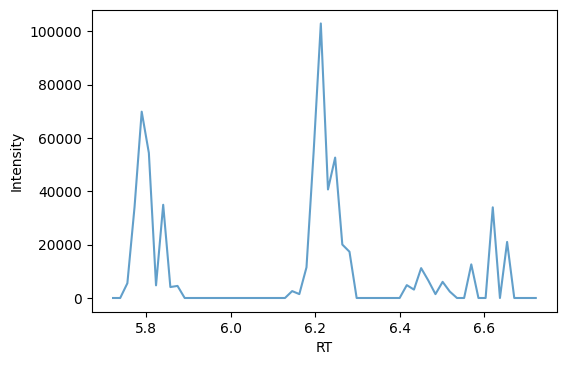

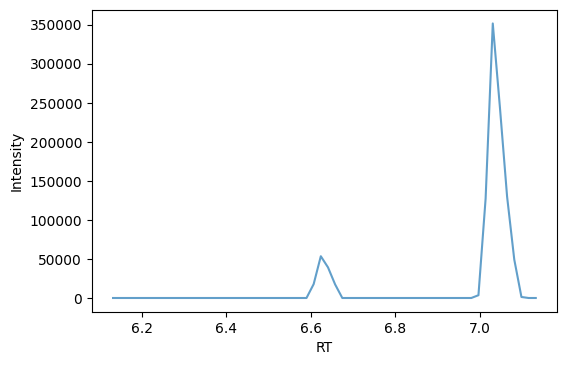

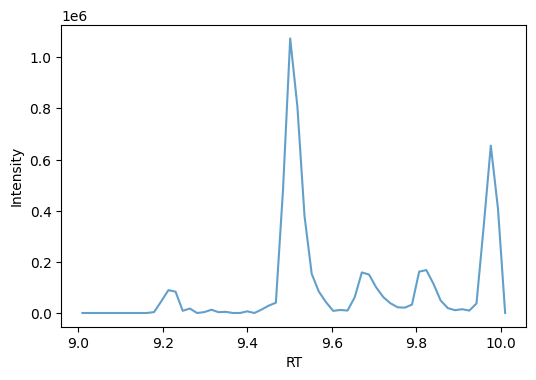

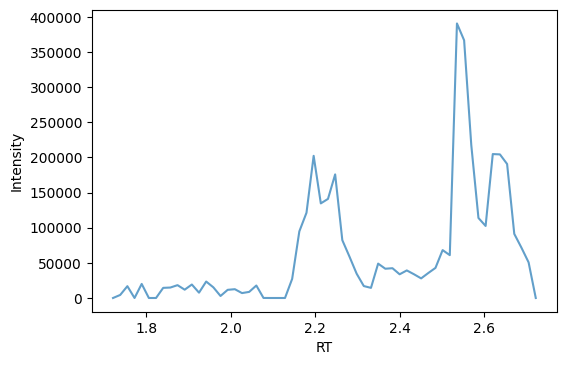

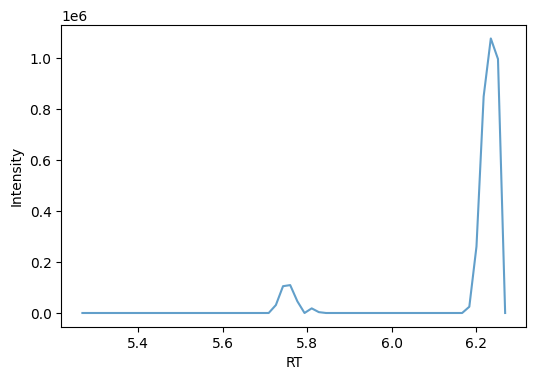

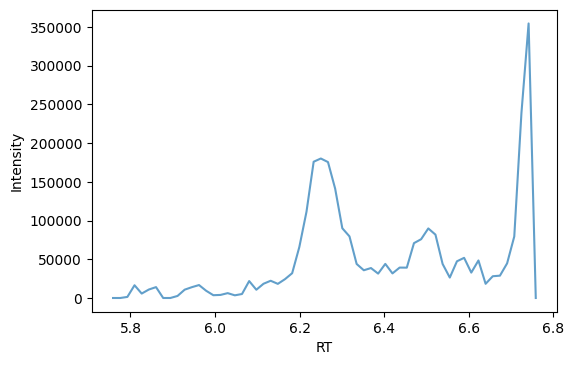

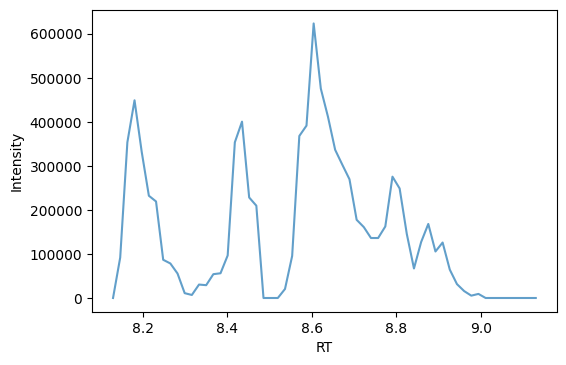

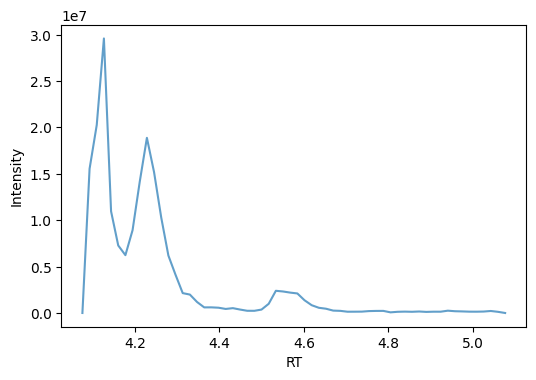

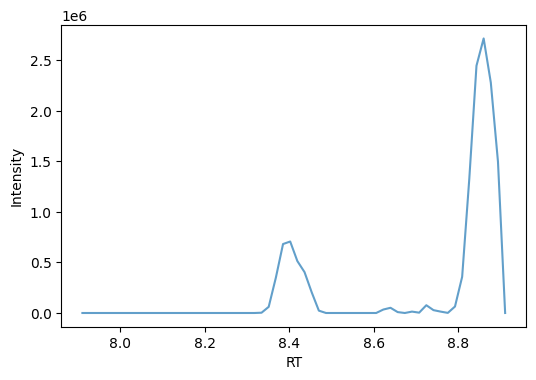

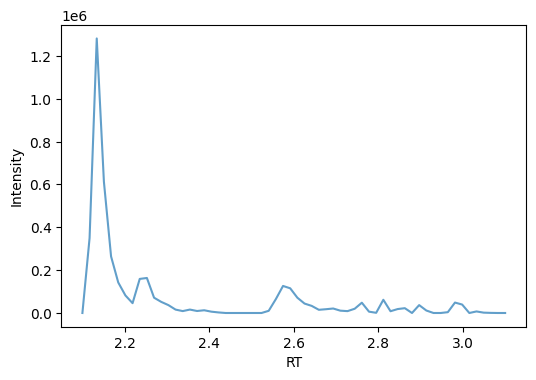

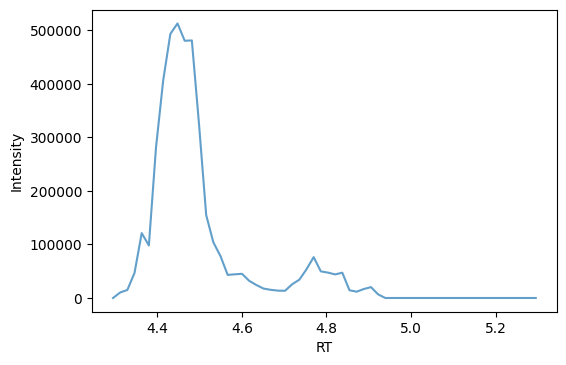

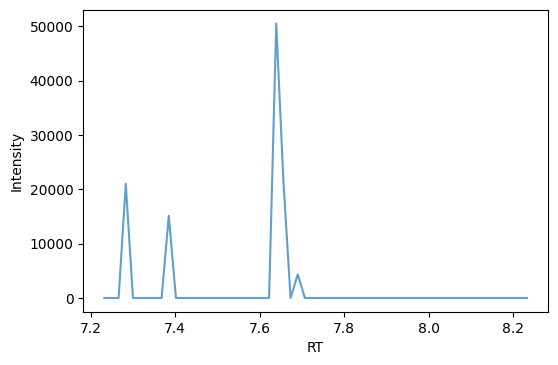

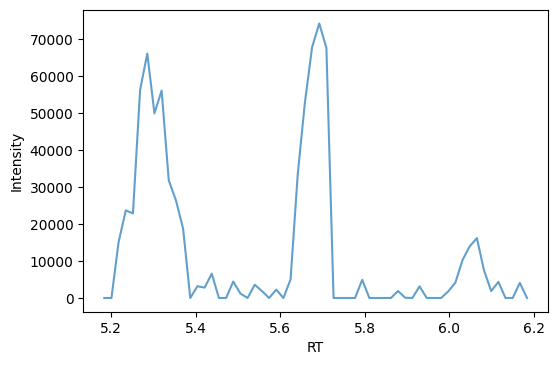

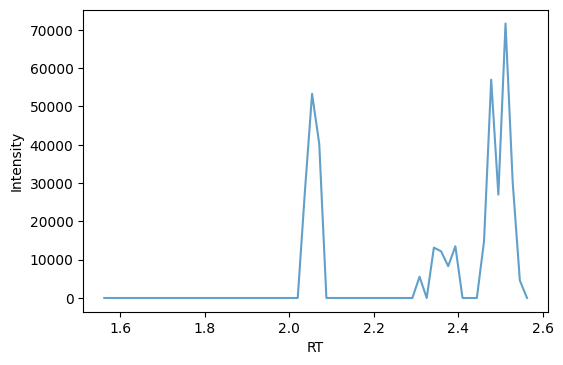

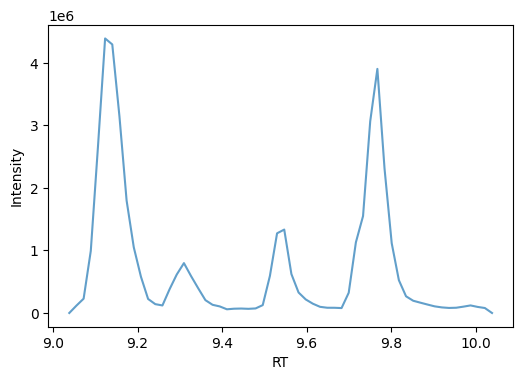

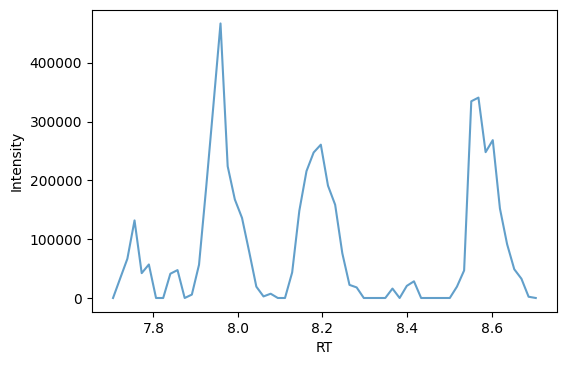

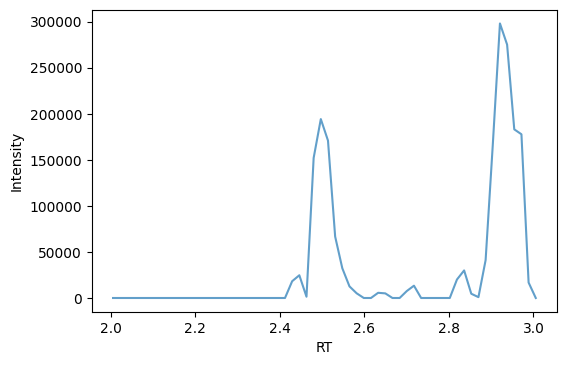

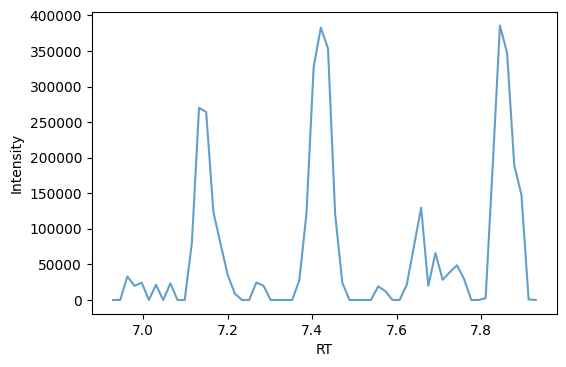

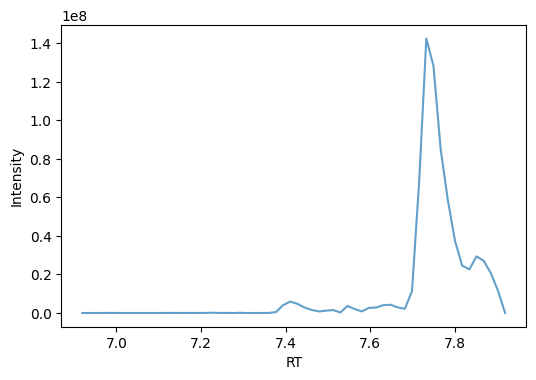

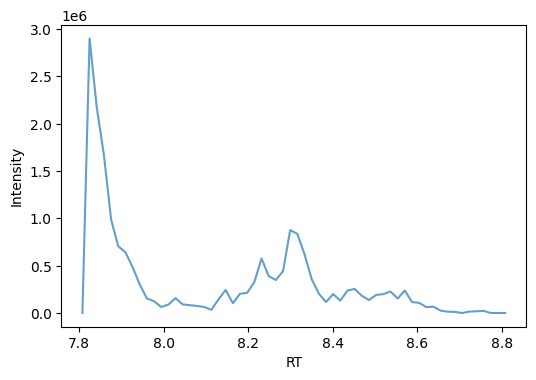

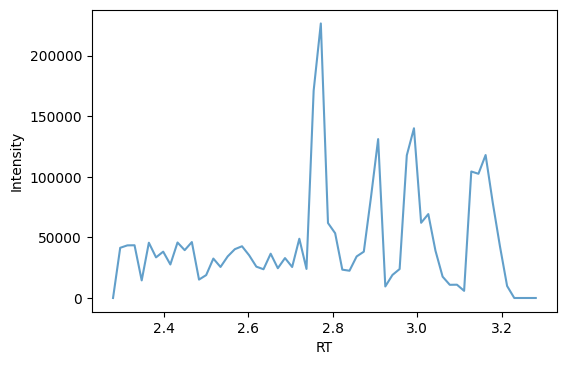

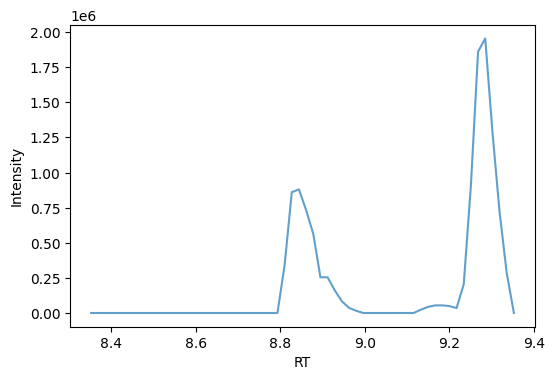

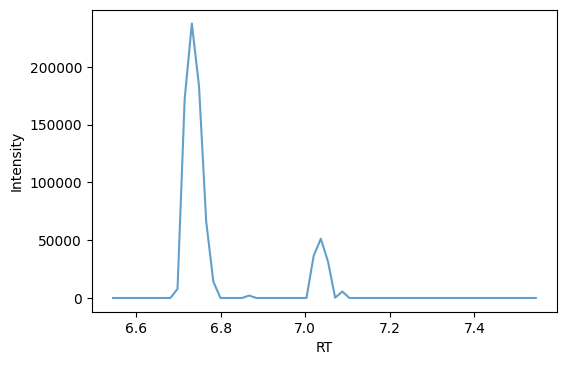

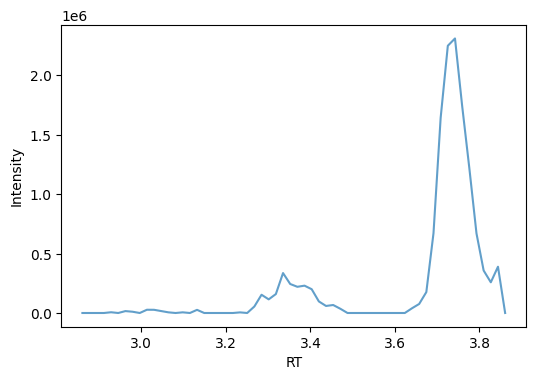

<Figure size 600x400 with 0 Axes>

In [152]:
for ind in fns:
    plot_overlayedEIC(raw_data[:1],peak_curated.at[ind,"mz"],peak_curated.at[ind,"rt"]-.5,peak_curated.at[ind,"rt"] + .5,resolution=resolution,alpha=0.7)
    plt.xlabel("RT")
    plt.ylabel("Intensity")
    plt.figure()

In [153]:
xcmsCols = [x for x in peakList.columns.values if ".mzML" in x]
xcms_peak_areas = peakList[xcmsCols]
xcms_peak_areas

QC_01.mzML    QC_02.mzML    QC_03.mzML    QC_04.mzML    QC_05.mzML  \
FT00001  1.974936e+06  1.858493e+06  1.798871e+06  1.757297e+06  1.773365e+06   
FT00002  2.826669e+07  2.815197e+07  2.841696e+07  2.881003e+07  3.145220e+07   
FT00003  8.213799e+06  9.725321e+06  9.307397e+06  7.713435e+06  8.139520e+06   
FT00004  3.205281e+05  3.206047e+05  2.857381e+05  3.124773e+05  3.306725e+05   
FT00005  2.072345e+05  1.836083e+05  2.224421e+05  1.704847e+05  2.148285e+05   
...               ...           ...           ...           ...           ...   
FT32177  1.895676e+04  0.000000e+00  1.190416e+05  1.293768e+04  7.919847e+04   
FT32178  7.459506e+04  1.379095e+05  1.272461e+05  1.030717e+05  1.344736e+05   
FT32179  1.857563e+05  1.975252e+05  2.361436e+05  2.210434e+05  2.238891e+05   
FT32180  1.741973e+05  1.996532e+05  1.700717e+05  1.492381e+05  2.215041e+05   
FT32181  1.102636e+05  4.369822e+04  1.171374e+05  1.096281e+05  7.411829e+04   

           QC_06.mzML    QC_07.mzML  
FT00001  1.768485e+06  2.304243e+06  
FT00002  3.074870e+07  3.318160e+07  
FT00003  7.220048e+06  8.205855e+06  
FT00004  3.484202e+05  3.416744e+05  
FT00005  1.860289e+05  2.334494e+05  
...               ...           ...  
FT32177  0.000000e+00  2.039624e+05  
FT32178  1.053646e+05  7.916662e+04  
FT32179  2.395129e+05  2.108537e+05  
FT32180  1.772771e+05  2.104139e+05  
FT32181  1.437213e+05  1.249721e+05  

[32181 rows x 7 columns]

In [154]:
pdCols = [x for x in peak_intensities.columns.values if ".mzML" in x and "D:" in x]
pd_peak_areas = peak_intensities[pdCols]
pd_peak_areas

D:/PeakDetective/data/ST001882_GT_RP_Positive/QC_01.mzML  \
FT00001                                       1.769880e+06          
FT00002                                       2.521567e+07          
FT00003                                       4.741310e+06          
FT00004                                       3.247647e+05          
FT00005                                       1.850511e+05          
...                                                    ...          
FT32177                                       4.207918e+04          
FT32178                                       6.889721e+04          
FT32179                                       1.720790e+05          
FT32180                                       1.806937e+05          
FT32181                                       9.584854e+04          

         D:/PeakDetective/data/ST001882_GT_RP_Positive/QC_02.mzML  \
FT00001                                       1.599984e+06          
FT00002                                       2.381203e+07          
FT00003                                       4.257582e+06          
FT00004                                       3.231905e+05          
FT00005                                       1.582392e+05          
...                                                    ...          
FT32177                                       4.771996e+04          
FT32178                                       1.031815e+05          
FT32179                                       1.851172e+05          
FT32180                                       1.856440e+05          
FT32181                                       9.903905e+04          

         D:/PeakDetective/data/ST001882_GT_RP_Positive/QC_03.mzML  \
FT00001                                       1.656394e+06          
FT00002                                       2.534021e+07          
FT00003                                       4.067955e+06          
FT00004                                       3.037227e+05          
FT00005                                       1.510327e+05          
...                                                    ...          
FT32177                                       6.576219e+04          
FT32178                                       1.386527e+05          
FT32179                                       1.822445e+05          
FT32180                                       1.799968e+05          
FT32181                                       1.129964e+05          

         D:/PeakDetective/data/ST001882_GT_RP_Positive/QC_04.mzML  \
FT00001                                       1.704545e+06          
FT00002                                       2.639797e+07          
FT00003                                       4.210701e+06          
FT00004                                       3.570118e+05          
FT00005                                       1.554421e+05          
...                                                    ...          
FT32177                                       4.930834e+04          
FT32178                                       5.308025e+04          
FT32179                                       2.330227e+05          
FT32180                                       1.437726e+05          
FT32181                                       1.035921e+05          

         D:/PeakDetective/data/ST001882_GT_RP_Positive/QC_05.mzML  \
FT00001                                       1.706611e+06          
FT00002                                       2.793932e+07          
FT00003                                       4.377255e+06          
FT00004                                       2.937403e+05          
FT00005                                       1.845383e+05          
...                                                    ...          
FT32177                                       3.855859e+04          
FT32178                                       1.379266e+05          
FT32179                                       2.796678e+05          
FT3

0.5026492992412817


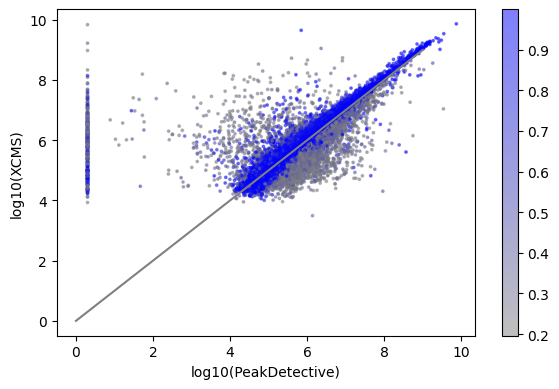

In [155]:
plt.scatter(np.log10(pd_peak_areas.values.mean(axis=1)+2),np.log10(xcms_peak_areas.values.mean(axis=1)),s=3,alpha=0.5,c=peak_scores[pdCols].values.mean(axis=1),cmap = LinearSegmentedColormap.from_list("test",colors=["grey", "blue"],N=256)
)
plt.plot([0,9],[0,9],color="grey")
plt.xlabel("log10(PeakDetective)")
plt.ylabel("log10(XCMS)")
cbar = plt.colorbar()
print(met.r2_score(pd_peak_areas.values.mean(axis=1),xcms_peak_areas.values.mean(axis=1)))
plt.tight_layout()
plt.savefig(datadir + "intensity_scatter.png",dpi=300)

Method          CV
0      PeakDetective    6.525364
1      PeakDetective    8.394036
2      PeakDetective    5.225600
3      PeakDetective    6.620982
4      PeakDetective    9.465792
...              ...         ...
64357           XCMS  115.079042
64358           XCMS   21.797760
64359           XCMS    8.427149
64360           XCMS   12.627300
64361           XCMS   30.126007

[64362 rows x 2 columns]

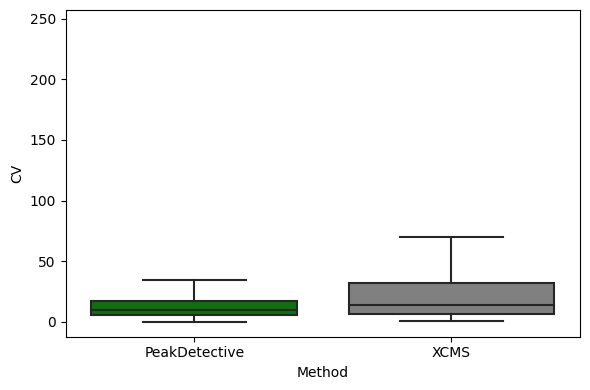

In [156]:
#TODO add cv results to each
plt_df = {}
for index,row in pd_peak_areas.iterrows():
    if np.mean(row.values) > 1:
        plt_df[len(plt_df)] = {"Method":"PeakDetective","CV":100*np.std(row.values)/np.mean(row.values)}
    else:
        plt_df[len(plt_df)] = {"Method":"PeakDetective","CV":0}
        
for index,row in xcms_peak_areas.iterrows():
    if np.mean(row.values) > 1:
        plt_df[len(plt_df)] = {"Method":"XCMS","CV":100*np.std(row.values)/np.mean(row.values)}
    else:
        plt_df[len(plt_df)] = {"Method":"XCMS","CV":0}
    
plt_df = pd.DataFrame.from_dict(plt_df,orient="index")
sb.boxplot(data=plt_df,x="Method",y="CV",fliersize=0,palette={"XCMS":"grey","PeakDetective":"green"})
plt.tight_layout()
plt.savefig(datadir+"cv_boxplot.png",dpi=300)
plt_df

In [157]:
print(plt_df[plt_df["Method"] == "PeakDetective"]["CV"].values.mean(),plt_df[plt_df["Method"] == "PeakDetective"]["CV"].values.std())
print(plt_df[plt_df["Method"] == "XCMS"]["CV"].values.mean(),plt_df[plt_df["Method"] == "XCMS"]["CV"].values.std())

14.428776058550392 17.435217845294417
24.569584028900177 29.05938638911188
